In [15]:
import pandas as pd

pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_rows',None)

### 1 DATA PREPARATION & CLEANING STRATEGY
####  1.1 Initial Data Quality Assessment

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Load data
claims_df = pd.read_csv('uk_pmi_claims_200k.csv')
members_df = pd.read_csv('uk_pmi_membership_120k.csv')

def initial_data_assessment(df, table_name):
    """Comprehensive data quality check"""
    print(f"\n{'='*60}")
    print(f"DATA QUALITY ASSESSMENT: {table_name}")
    print(f"{'='*60}")
    
    print(f"\n1. Shape: {df.shape}")
    print(f"\n2. Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    print(f"\n3. Duplicates: {df.duplicated().sum()}")
    
    print(f"\n4. Missing Values:")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing_Count': missing,
        'Missing_Percentage': missing_pct
    }).sort_values('Missing_Percentage', ascending=False)
    print(missing_df[missing_df['Missing_Count'] > 0])
    
    print(f"\n5. Data Types:")
    print(df.dtypes.value_counts())
    
    return missing_df

# Assess both tables
claims_quality = initial_data_assessment(claims_df, "CLAIMS TABLE")
members_quality = initial_data_assessment(members_df, "MEMBERSHIP TABLE")


DATA QUALITY ASSESSMENT: CLAIMS TABLE

1. Shape: (200000, 28)

2. Memory Usage: 268.01 MB

3. Duplicates: 0

4. Missing Values:
                        Missing_Count  Missing_Percentage
Discharge Date                 175607             87.8035
Admission Date                 175607             87.8035
Ancillary Service Type          48116             24.0580

5. Data Types:
object     24
int64       2
float64     2
Name: count, dtype: int64

DATA QUALITY ASSESSMENT: MEMBERSHIP TABLE

1. Shape: (120000, 17)

2. Memory Usage: 104.26 MB

3. Duplicates: 0

4. Missing Values:
            Missing_Count  Missing_Percentage
Lapse Date         108037           90.030833

5. Data Types:
object    16
int64      1
Name: count, dtype: int64


In [10]:
members_df.rename(columns={'Unique ID': 'Claimant Unique ID'}, inplace=True)

In [ ]:
members_df.col

Index(['Client Name', 'Client Identifier', 'Scheme Category/ Section Name',
       'Scheme Category/ Section Name Identifier', 'Unique Member Reference',
       'Unique ID', 'Status of Member', 'Status of Registration',
       'Year of Birth', 'Gender', 'Short Post Code of Member',
       'Contract Start Date', 'Contract End Date', 'Original Date of Joining',
       'Scheme Policy Joining Date', 'Registration Status', 'Lapse Date'],
      dtype='object')

In [7]:
claims_df.columns

Index(['Client Name', 'Client Identifier', 'Scheme Category/ Section Name',
       'Scheme Category/ Section Name Identifier', 'Status of Member',
       'Claimant Unique ID', 'Claimant Year of Birth', 'Claimant Gender',
       'Short Post Code', 'Unique Member Reference', 'Contract Start Date',
       'Contract End Date', 'Claim ID', 'Incurred Date', 'Paid Date',
       'Condition Code', 'Impairment Code', 'Condition Category',
       'Treatment Type', 'Claim Type', 'Ancillary Service Type',
       'Treatment Location', 'Provider Type', 'Admission Date',
       'Discharge Date', 'Calculate Length of Service', 'Claim Amount',
       'Amount Paid'],
      dtype='object')

#### 1.2 Data Cleaning Pipeline

In [11]:
def clean_claims_data(df):
    """Comprehensive claims data cleaning"""
    
    df_clean = df.copy()
    
    # 1. STANDARDIZE COLUMN NAMES
    df_clean.columns = df_clean.columns.str.strip().str.lower().str.replace(' ', '_')
    
    # 2. HANDLE DATES - Convert all date columns
    date_columns = ['paid_date', 'incurred_date', 'admission_date', 
                   'discharge_date', 'contract_start_date', 'contract_end_date']
    
    for col in date_columns:
        if col in df_clean.columns:
            df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
    
    # 3. REMOVE INVALID CLAIMS
    # Remove claims with negative or zero amounts
    if 'claim_amount' in df_clean.columns:
        df_clean = df_clean[df_clean['claim_amount'] > 0]
    
    # Remove claims with future paid dates
    if 'paid_date' in df_clean.columns:
        df_clean = df_clean[df_clean['paid_date'] <= pd.Timestamp.now()]
    
    # Remove claims where incurred > paid date (data error)
    if 'incurred_date' in df_clean.columns and 'paid_date' in df_clean.columns:
        df_clean = df_clean[df_clean['incurred_date'] <= df_clean['paid_date']]
    
    # 4. HANDLE MISSING VALUES
    
    # Treatment Type - Fill with 'Unknown' or most frequent
    if 'treatment_type' in df_clean.columns:
        df_clean['treatment_type'].fillna('Unknown', inplace=True)
    
    # Provider Type - Fill with 'Unknown'
    if 'provider_type' in df_clean.columns:
        df_clean['provider_type'].fillna('Unknown', inplace=True)
    
    # Treatment Location - Fill with mode
    if 'treatment_location' in df_clean.columns:
        df_clean['treatment_location'].fillna(
            df_clean['treatment_location'].mode()[0] if not df_clean['treatment_location'].mode().empty else 'Unknown',
            inplace=True
        )
    
    # Condition Category - Critical field, fill strategically
    if 'condition_category' in df_clean.columns:
        df_clean['condition_category'].fillna('Unspecified', inplace=True)
    
    # Discharge date - can be derived or filled
    if 'admission_date' in df_clean.columns and 'discharge_date' in df_clean.columns:
        # If admission exists but discharge missing, assume same-day treatment
        mask = df_clean['admission_date'].notna() & df_clean['discharge_date'].isna()
        df_clean.loc[mask, 'discharge_date'] = df_clean.loc[mask, 'admission_date']
    
    # 5. STANDARDIZE CATEGORICAL VARIABLES
    
    # Gender standardization
    if 'claimant_gender' in df_clean.columns:
        gender_mapping = {
            'M': 'Male', 'F': 'Female', 'O': 'Other',
            'male': 'Male', 'female': 'Female', 'other': 'Other',
            'MALE': 'Male', 'FEMALE': 'Female', 'OTHER': 'Other'
        }
        df_clean['claimant_gender'] = df_clean['claimant_gender'].map(
            lambda x: gender_mapping.get(x, x) if pd.notna(x) else 'Unknown'
        )
    
    # Status standardization
    if 'status_of_member' in df_clean.columns:
        df_clean['status_of_member'] = df_clean['status_of_member'].str.strip().str.title()
    
    # 6. HANDLE OUTLIERS IN CLAIM AMOUNTS (using IQR method with domain knowledge)
    if 'claim_amount' in df_clean.columns:
        Q1 = df_clean['claim_amount'].quantile(0.25)
        Q3 = df_clean['claim_amount'].quantile(0.75)
        IQR = Q3 - Q1
        
        # Flag outliers but don't remove (they're important for high-cost prediction!)
        df_clean['is_outlier'] = (
            (df_clean['claim_amount'] < (Q1 - 3 * IQR)) | 
            (df_clean['claim_amount'] > (Q3 + 3 * IQR))
        ).astype(int)
    
    # 7. CREATE CLAIM ID if not exists
    if 'claim_id' not in df_clean.columns:
        df_clean['claim_id'] = range(1, len(df_clean) + 1)
    
    # 8. REMOVE DUPLICATES
    df_clean = df_clean.drop_duplicates(subset=['claim_id'], keep='first')
    
    print(f"Claims Cleaning Summary:")
    print(f"Original rows: {len(df)}")
    print(f"Cleaned rows: {len(df_clean)}")
    print(f"Rows removed: {len(df) - len(df_clean)} ({((len(df) - len(df_clean))/len(df)*100):.2f}%)")
    
    return df_clean


def clean_membership_data(df):
    """Comprehensive membership data cleaning"""
    
    df_clean = df.copy()
    
    # 1. STANDARDIZE COLUMN NAMES
    df_clean.columns = df_clean.columns.str.strip().str.lower().str.replace(' ', '_')
    
    # 2. HANDLE DATES
    date_columns = ['contract_staart_date', 'contract_end_date', 
                   'original_date_of_joining', 'sscheme_policy_joining_date', 'lapse_date']
    
    for col in date_columns:
        if col in df_clean.columns:
            df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
    
    # 3. HANDLE YEAR OF BIRTH
    if 'year_of_birth' in df_clean.columns:
        current_year = datetime.now().year
        # Remove invalid birth years
        df_clean = df_clean[
            (df_clean['year_of_birth'] >= 1920) & 
            (df_clean['year_of_birth'] <= current_year)
        ]
    
    if 'claimant_year_of_birth' in df_clean.columns:
        current_year = datetime.now().year
        df_clean = df_clean[
            (df_clean['claimant_year_of_birth'] >= 1920) & 
            (df_clean['claimant_year_of_birth'] <= current_year)
        ]
    
    # 4. STANDARDIZE GENDER
    if 'gender' in df_clean.columns:
        gender_mapping = {
            'M': 'Male', 'F': 'Female', 'O': 'Other',
            'male': 'Male', 'female': 'Female', 'other': 'Other',
            'MALE': 'Male', 'FEMALE': 'Female', 'OTHER': 'Other'
        }
        df_clean['gender'] = df_clean['gender'].map(
            lambda x: gender_mapping.get(x, x) if pd.notna(x) else 'Unknown'
        )
    
    # 5. HANDLE MEMBER STATUS
    if 'status_of_member' in df_clean.columns:
        df_clean['status_of_member'] = df_clean['status_of_member'].str.strip().str.title()
        df_clean['status_of_member'].fillna('Active', inplace=True)
    
    # 6. HANDLE REGISTRATION STATUS
    if 'registration_status' in df_clean.columns:
        df_clean['registration_status'] = df_clean['registration_status'].str.strip().str.title()
        df_clean['registration_status'].fillna('Registered', inplace=True)
    
    # 7. HANDLE STATUS OF REGISTRATION
    if 'status_of_registration' in df_clean.columns:
        df_clean['status_of_registration'] = df_clean['status_of_registration'].str.strip().str.title()
    
    # 8. POSTCODE CLEANING
    if 'short_post_code' in df_clean.columns:
        df_clean['short_post_code'] = df_clean['short_post_code'].str.strip().str.upper()
    
    if 'short_post_code_of_member' in df_clean.columns:
        df_clean['short_post_code_of_member'] = df_clean['short_post_code_of_member'].str.strip().str.upper()
    
    # 9. REMOVE DUPLICATES
    if 'unique_id' in df_clean.columns:
        df_clean = df_clean.drop_duplicates(subset=['unique_id'], keep='first')
    elif 'claimant_unique_id' in df_clean.columns:
        df_clean = df_clean.drop_duplicates(subset=['claimant_unique_id'], keep='first')
    
    print(f"\nMembership Cleaning Summary:")
    print(f"Original rows: {len(df)}")
    print(f"Cleaned rows: {len(df_clean)}")
    print(f"Rows removed: {len(df) - len(df_clean)} ({((len(df) - len(df_clean))/len(df)*100):.2f}%)")
    
    return df_clean

# Apply cleaning
claims_clean = clean_claims_data(claims_df)
members_clean = clean_membership_data(members_df)

Claims Cleaning Summary:
Original rows: 200000
Cleaned rows: 198278
Rows removed: 1722 (0.86%)

Membership Cleaning Summary:
Original rows: 120000
Cleaned rows: 120000
Rows removed: 0 (0.00%)


### 2. FEATURE ENGINEERING - COMPREHENSIVE
####  2.1 Member-Level Features

In [13]:
def create_member_features(members_df):
    """Create rich member-level features"""
    
    df = members_df.copy()
    current_date = pd.Timestamp.now()
    
    # ============================================
    # DEMOGRAPHIC FEATURES
    # ============================================
    
    # Age calculation
    if 'year_of_birth' in df.columns:
        df['current_age'] = current_date.year - df['year_of_birth']
        
        # Age bands
        df['age_band'] = pd.cut(df['current_age'], 
                                bins=[0, 18, 30, 40, 50, 60, 70, 120],
                                labels=['0-18', '19-30', '31-40', '41-50', 
                                       '51-60', '61-70', '70+'])
        
        # Age risk categories (based on PMI domain knowledge)
        df['age_risk_category'] = pd.cut(df['current_age'],
                                         bins=[0, 35, 55, 120],
                                         labels=['Low', 'Medium', 'High'])
    
    # Gender encoding
    if 'gender' in df.columns:
        df['gender_encoded'] = df['gender'].map({'Male': 1, 'Female': 2, 'Other': 3, 'Unknown': 0})
    
    # ============================================
    # MEMBERSHIP TENURE FEATURES
    # ============================================
    
    if 'original_date_of_joining' in df.columns:
        df['membership_tenure_days'] = (current_date - df['original_date_of_joining']).dt.days
        df['membership_tenure_years'] = df['membership_tenure_days'] / 365.25
        df['membership_tenure_months'] = df['membership_tenure_days'] / 30.44
        
        # Tenure categories
        df['tenure_category'] = pd.cut(df['membership_tenure_years'],
                                       bins=[-np.inf, 1, 3, 5, 10, np.inf],
                                       labels=['New(<1yr)', 'Recent(1-3yr)', 
                                              'Established(3-5yr)', 'Mature(5-10yr)', 
                                              'Long-term(10+yr)'])
    
    if 'sscheme_policy_joining_date' in df.columns:
        df['scheme_tenure_days'] = (current_date - df['sscheme_policy_joining_date']).dt.days
        df['scheme_tenure_months'] = df['scheme_tenure_days'] / 30.44
    
    # ============================================
    # CONTRACT FEATURES
    # ============================================
    
    if 'contract_staart_date' in df.columns and 'contract_end_date' in df.columns:
        df['contract_duration_days'] = (df['contract_end_date'] - df['contract_staart_date']).dt.days
        df['contract_remaining_days'] = (df['contract_end_date'] - current_date).dt.days
        df['contract_elapsed_ratio'] = (current_date - df['contract_staart_date']).dt.days / df['contract_duration_days']
        df['contract_elapsed_ratio'] = df['contract_elapsed_ratio'].clip(0, 1)
        
        # Contract renewal proximity
        df['near_renewal'] = (df['contract_remaining_days'] <= 90).astype(int)
        df['contract_expired'] = (df['contract_remaining_days'] < 0).astype(int)
        
        # Contract year (useful for seasonality)
        df['contract_year'] = df['contract_staart_date'].dt.year
        df['contract_start_month'] = df['contract_staart_date'].dt.month
        df['contract_start_quarter'] = df['contract_staart_date'].dt.quarter
    
    # ============================================
    # STATUS & REGISTRATION FEATURES
    # ============================================
    
    if 'status_of_member' in df.columns:
        df['is_active'] = (df['status_of_member'] == 'Active').astype(int)
    
    if 'registration_status' in df.columns:
        df['is_registered'] = (df['registration_status'] == 'Registered').astype(int)
    
    if 'lapse_date' in df.columns:
        df['has_lapsed'] = df['lapse_date'].notna().astype(int)
        df['days_since_lapse'] = (current_date - df['lapse_date']).dt.days
    
    # ============================================
    # GEOGRAPHIC FEATURES
    # ============================================
    
    if 'short_post_code' in df.columns:
        # Extract postcode area (first 1-2 letters)
        df['postcode_area'] = df['short_post_code'].str.extract(r'^([A-Z]{1,2})', expand=False)
        
        # Postcode frequency (can indicate urban/rural)
        postcode_counts = df['short_post_code'].value_counts()
        df['postcode_frequency'] = df['short_post_code'].map(postcode_counts)
        
        # Number of members in same postcode
        df['members_same_postcode'] = df.groupby('short_post_code')['claimant_unique_id'].transform('count') #######################################################
    
    # ============================================
    # SCHEME/CATEGORY FEATURES
    # ============================================
    
    if 'scheme_category/_section_name' in df.columns:
        # Scheme type encoding
        df['scheme_type'] = df['scheme_category/_section_name'].astype('category')
        
        # Number of members in same scheme
        df['members_same_scheme'] = df.groupby('scheme_category/_section_name')['claimant_unique_id'].transform('count')
    
    if 'industry_type' in df.columns:
        df['industry_category'] = df['industry_type'].astype('category')
        df['members_same_industry'] = df.groupby('industry_type')['claimant_unique_id'].transform('count')
    
    # ============================================
    # TEMPORAL FEATURES (Current date based)
    # ============================================
    
    df['current_year'] = current_date.year
    df['current_month'] = current_date.month
    df['current_quarter'] = current_date.quarter
    df['current_day_of_year'] = current_date.dayofyear
    df['current_week_of_year'] = current_date.isocalendar().week
    
    # Seasonality indicators
    df['is_winter'] = df['current_month'].isin([12, 1, 2]).astype(int)
    df['is_summer'] = df['current_month'].isin([6, 7, 8]).astype(int)
    df['is_flu_season'] = df['current_month'].isin([10, 11, 12, 1, 2, 3]).astype(int)
    
    return df


def create_claims_features(claims_df, reference_date=None):
    """Create comprehensive claim-level features"""
    
    df = claims_df.copy()
    
    if reference_date is None:
        reference_date = pd.Timestamp.now()
    
    # ============================================
    # CLAIM AMOUNT FEATURES
    # ============================================
    
    if 'claim_amount' in df.columns:
        # Log transformation for skewed distribution
        df['claim_amount_log'] = np.log1p(df['claim_amount'])
        
        # Amount categories
        df['claim_amount_band'] = pd.cut(df['claim_amount'],
                                         bins=[0, 500, 1000, 2500, 5000, 10000, np.inf],
                                         labels=['Very Low', 'Low', 'Medium', 
                                                'High', 'Very High', 'Critical'])
        
        # High cost claim flag (top 10%)
        high_cost_threshold = df['claim_amount'].quantile(0.90)
        df['is_high_cost_claim'] = (df['claim_amount'] >= high_cost_threshold).astype(int)
        
        # Catastrophic claim flag (top 1%)
        catastrophic_threshold = df['claim_amount'].quantile(0.99)
        df['is_catastrophic_claim'] = (df['claim_amount'] >= catastrophic_threshold).astype(int)
    
    if 'amount_paid' in df.columns:
        df['amount_paid_log'] = np.log1p(df['amount_paid'])
    
    # ============================================
    # TEMPORAL FEATURES - PAID DATE
    # ============================================
    
    if 'paid_date' in df.columns:
        df['paid_year'] = df['paid_date'].dt.year
        df['paid_month'] = df['paid_date'].dt.month
        df['paid_quarter'] = df['paid_date'].dt.quarter
        df['paid_day_of_week'] = df['paid_date'].dt.dayofweek
        df['paid_day_of_month'] = df['paid_date'].dt.day
        df['paid_week_of_year'] = df['paid_date'].dt.isocalendar().week
        df['paid_day_of_year'] = df['paid_date'].dt.dayofyear
        
        # Business vs weekend
        df['paid_on_weekend'] = (df['paid_day_of_week'] >= 5).astype(int)
        
        # Season paid
        df['paid_season'] = df['paid_month'] % 12 // 3 + 1  # 1=Winter, 2=Spring, 3=Summer, 4=Fall
        df['paid_in_winter'] = df['paid_month'].isin([12, 1, 2]).astype(int)
        df['paid_in_flu_season'] = df['paid_month'].isin([10, 11, 12, 1, 2, 3]).astype(int)
        
        # Days since paid
        df['days_since_paid'] = (reference_date - df['paid_date']).dt.days
        df['months_since_paid'] = df['days_since_paid'] / 30.44
        
        # Recency categories
        df['claim_recency'] = pd.cut(df['days_since_paid'],
                                     bins=[-np.inf, 30, 90, 180, 365, np.inf],
                                     labels=['Very Recent', 'Recent', 'Moderate', 
                                            'Old', 'Very Old'])
    
    # ============================================
    # TEMPORAL FEATURES - INCURRED DATE
    # ============================================
    
    if 'incurred_date' in df.columns:
        df['incurred_year'] = df['incurred_date'].dt.year
        df['incurred_month'] = df['incurred_date'].dt.month
        df['incurred_quarter'] = df['incurred_date'].dt.quarter
        df['incurred_day_of_week'] = df['incurred_date'].dt.dayofweek
        df['incurred_week_of_year'] = df['incurred_date'].dt.isocalendar().week
        
        # Days since incurred
        df['days_since_incurred'] = (reference_date - df['incurred_date']).dt.days
    
    # ============================================
    # CLAIM PROCESSING FEATURES
    # ============================================
    
    if 'incurred_date' in df.columns and 'paid_date' in df.columns:
        df['processing_time_days'] = (df['paid_date'] - df['incurred_date']).dt.days
        df['processing_time_weeks'] = df['processing_time_days'] / 7
        
        # Processing speed category
        df['processing_speed'] = pd.cut(df['processing_time_days'],
                                        bins=[-np.inf, 7, 30, 90, np.inf],
                                        labels=['Fast', 'Normal', 'Slow', 'Very Slow'])
        
        # Delayed claim flag
        df['is_delayed_claim'] = (df['processing_time_days'] > 90).astype(int)
    
    # ============================================
    # ADMISSION & LENGTH OF STAY FEATURES
    # ============================================
    
    if 'admission_date' in df.columns and 'discharge_date' in df.columns:
        df['length_of_stay_days'] = (df['discharge_date'] - df['admission_date']).dt.days
        df['length_of_stay_category'] = pd.cut(df['length_of_stay_days'],
                                               bins=[-np.inf, 0, 1, 3, 7, 14, np.inf],
                                               labels=['Day_Case', 'Overnight', 'Short', 
                                                      'Medium', 'Long', 'Extended'])
        
        # Inpatient vs outpatient
        df['is_inpatient'] = (df['length_of_stay_days'] > 0).astype(int)
        
        # Admission day of week
        df['admission_day_of_week'] = df['admission_date'].dt.dayofweek
        df['admitted_on_weekend'] = (df['admission_day_of_week'] >= 5).astype(int)
        
        # Emergency indicator (weekend admissions often emergency)
        df['likely_emergency'] = df['admitted_on_weekend']
    
    # ============================================
    # CONDITION & TREATMENT FEATURES
    # ============================================
    
    if 'condition_category' in df.columns:
        # Create dummy variables for condition
        df['condition_category_encoded'] = df['condition_category'].astype('category')
        
        # Flag chronic conditions (domain knowledge)
        chronic_keywords = ['diabetes', 'cancer', 'cardiac', 'renal', 'chronic']
        df['is_chronic_condition'] = df['condition_category'].str.lower().str.contains(
            '|'.join(chronic_keywords), na=False).astype(int)
    
    if 'condition_code' in df.columns:
        # ICD code level (first 3 characters usually category)
        df['condition_code_category'] = df['condition_code'].astype(str).str[:3]
    
    if 'treatment_type' in df.columns:
        df['treatment_category'] = df['treatment_type'].astype('category')
        
        # Flag major treatments
        major_keywords = ['surgery', 'operation', 'transplant', 'bypass']
        df['is_major_treatment'] = df['treatment_type'].str.lower().str.contains(
            '|'.join(major_keywords), na=False).astype(int)
    
    if 'ancillary_service_type' in df.columns:
        # Flag physiotherapy, diagnostics etc
        df['has_ancillary_service'] = df['ancillary_service_type'].notna().astype(int)
    
    # ============================================
    # PROVIDER & LOCATION FEATURES
    # ============================================
    
    if 'provider_type' in df.columns:
        df['provider_category'] = df['provider_type'].astype('category')
        
        # Count claims per provider
        df['provider_claim_count'] = df.groupby('provider_type')['claim_id'].transform('count')
    
    if 'treatment_location' in df.columns:
        df['location_category'] = df['treatment_location'].astype('category')
        
        # Claims per location
        df['location_claim_count'] = df.groupby('treatment_location')['claim_id'].transform('count')
    
    # ============================================
    # IMPAIRMENT FEATURES
    # ============================================
    
    if 'impairment_code' in df.columns:
        df['has_impairment'] = df['impairment_code'].notna().astype(int)
    
    # ============================================
    # CLAIM TYPE FEATURES
    # ============================================
    
    if 'claim_type' in df.columns:
        df['claim_type_category'] = df['claim_type'].astype('category')
    
    return df

def safe_qcut(series, q=5, labels=[1,2,3,4,5]):
    """
    Safe quantile cut that avoids ValueError when not enough unique values.
    Falls back to fewer bins if necessary.
    """
    series = series.fillna(0)
    unique_vals = series.nunique()
    if unique_vals == 0:
        return pd.Series([1] * len(series), index=series.index)
    q_eff = min(q, unique_vals)
    labels_eff = labels[:q_eff]
    return pd.qcut(series.rank(method='first'), q=q_eff, labels=labels_eff, duplicates='drop')


def create_aggregated_member_claim_features(claims_df, members_df, observation_date=None):
    """
    Create powerful aggregated features by combining claims and membership
    This is the KEY for prediction - member claim history!
    """
    
    if observation_date is None:
        observation_date = pd.Timestamp.now()
    
    # Filter claims up to observation date (for proper train/test split later)
    historical_claims = claims_df[claims_df['paid_date'] <= observation_date].copy()
    
    # ============================================
    # MEMBER-LEVEL AGGREGATIONS
    # ============================================
    
    # Group by member
    member_id_col = 'claimant_unique_id' if 'claimant_unique_id' in historical_claims.columns else 'unique_id'
    
    # Total claim statistics
    member_agg = historical_claims.groupby(member_id_col).agg({
        'claim_amount': ['count', 'sum', 'mean', 'median', 'std', 'min', 'max'],
        'claim_id': 'count'
    }).reset_index()
    
    member_agg.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] 
                         for col in member_agg.columns]
    member_agg.rename(columns={f'{member_id_col}_': member_id_col}, inplace=True)
    
    # Rename for clarity
    member_agg.rename(columns={
        'claim_amount_count': 'total_claims',
        'claim_amount_sum': 'total_claim_amount',
        'claim_amount_mean': 'avg_claim_amount',
        'claim_amount_median': 'median_claim_amount',
        'claim_amount_std': 'std_claim_amount',
        'claim_amount_min': 'min_claim_amount',
        'claim_amount_max': 'max_claim_amount',
        'claim_id_count': 'total_claim_records'
    }, inplace=True)
    
    # ============================================
    # TIME-BASED AGGREGATIONS
    # ============================================
    
    # Last 12 months claims
    last_12m_date = observation_date - pd.DateOffset(months=12)
    claims_12m = historical_claims[historical_claims['paid_date'] > last_12m_date]
    
    member_12m = claims_12m.groupby(member_id_col).agg({
        'claim_amount': ['count', 'sum', 'mean'],
        'claim_id': 'count'
    }).reset_index()
    member_12m.columns = [f'{col[0]}_12m_{col[1]}' if col[1] else col[0] 
                          for col in member_12m.columns]
    member_12m.rename(columns={f'{member_id_col}_': member_id_col}, inplace=True)
    
    # Last 6 months claims
    last_6m_date = observation_date - pd.DateOffset(months=6)
    claims_6m = historical_claims[historical_claims['paid_date'] > last_6m_date]
    
    member_6m = claims_6m.groupby(member_id_col).agg({
        'claim_amount': ['count', 'sum', 'mean']
    }).reset_index()
    member_6m.columns = [f'{col[0]}_6m_{col[1]}' if col[1] else col[0] 
                         for col in member_6m.columns]
    member_6m.rename(columns={f'{member_id_col}_': member_id_col}, inplace=True)
    
    # Last 3 months claims
    last_3m_date = observation_date - pd.DateOffset(months=3)
    claims_3m = historical_claims[historical_claims['paid_date'] > last_3m_date]
    
    member_3m = claims_3m.groupby(member_id_col).agg({
        'claim_amount': ['count', 'sum', 'mean']
    }).reset_index()
    member_3m.columns = [f'{col[0]}_3m_{col[1]}' if col[1] else col[0] 
                         for col in member_3m.columns]
    member_3m.rename(columns={f'{member_id_col}_': member_id_col}, inplace=True)
    
    # ============================================
    # QUARTERLY AGGREGATIONS
    # ============================================
    
    if 'paid_quarter' in historical_claims.columns:
        quarterly_claims = historical_claims.groupby([member_id_col, 'paid_quarter']).agg({
            'claim_amount': ['count', 'sum']
        }).reset_index()
        
        # Average claims per quarter
        avg_quarterly = quarterly_claims.groupby(member_id_col).agg({
            ('claim_amount', 'count'): 'mean',
            ('claim_amount', 'sum'): 'mean'
        }).reset_index()
        avg_quarterly.columns = [member_id_col, 'avg_claims_per_quarter', 'avg_amount_per_quarter']
        
        member_agg = member_agg.merge(avg_quarterly, on=member_id_col, how='left')
    
    # ============================================
    # YEARLY AGGREGATIONS
    # ============================================
    
    if 'paid_year' in historical_claims.columns:
        yearly_claims = historical_claims.groupby([member_id_col, 'paid_year']).agg({
            'claim_amount': ['count', 'sum']
        }).reset_index()
        
        # Average claims per year
        avg_yearly = yearly_claims.groupby(member_id_col).agg({
            ('claim_amount', 'count'): 'mean',
            ('claim_amount', 'sum'): 'mean'
        }).reset_index()
        avg_yearly.columns = [member_id_col, 'avg_claims_per_year', 'avg_amount_per_year']
        
        member_agg = member_agg.merge(avg_yearly, on=member_id_col, how='left')
    
    # ============================================
    # HIGH-COST CLAIM FEATURES
    # ============================================
    
    # Define high cost threshold (90th percentile)
    high_cost_threshold = historical_claims['claim_amount'].quantile(0.90)
    high_cost_claims = historical_claims[historical_claims['claim_amount'] >= high_cost_threshold]
    
    high_cost_agg = high_cost_claims.groupby(member_id_col).agg({
        'claim_amount': ['count', 'sum', 'mean']
    }).reset_index()
    high_cost_agg.columns = [f'{col[0]}_high_cost_{col[1]}' if col[1] else col[0] 
                             for col in high_cost_agg.columns]
    high_cost_agg.rename(columns={f'{member_id_col}_': member_id_col}, inplace=True)
    
    # ============================================
    # CLAIM FREQUENCY PATTERNS
    # ============================================
    
    # Days between claims
    claims_sorted = historical_claims.sort_values([member_id_col, 'paid_date'])
    claims_sorted['days_since_last_claim'] = claims_sorted.groupby(member_id_col)['paid_date'].diff().dt.days
    
    claim_frequency = claims_sorted.groupby(member_id_col)['days_since_last_claim'].agg([
        ('avg_days_between_claims', 'mean'),
        ('median_days_between_claims', 'median'),
        ('min_days_between_claims', 'min')
    ]).reset_index()
    
    # ============================================
    # CLAIM TREND FEATURES
    # ============================================
    
    # Trend in claim amounts (increasing/decreasing)
    claims_sorted['claim_order'] = claims_sorted.groupby(member_id_col).cumcount() + 1
    
    # Calculate trend slope for each member (simple linear trend)
    def calculate_trend(group):
        if len(group) < 2:
            return 0
        x = group['claim_order'].values
        y = group['claim_amount'].values
        
        if len(x) > 1 and np.std(x) > 0:
            correlation = np.corrcoef(x, y)[0, 1]
            return correlation if not np.isnan(correlation) else 0
        return 0
    
    claim_trends = claims_sorted.groupby(member_id_col).apply(calculate_trend).reset_index()
    claim_trends.columns = [member_id_col, 'claim_amount_trend']
    
    # ============================================
    # RECENCY FEATURES
    # ============================================
    
    last_claim = historical_claims.groupby(member_id_col)['paid_date'].max().reset_index()
    last_claim.columns = [member_id_col, 'last_claim_date']
    last_claim['days_since_last_claim'] = (observation_date - last_claim['last_claim_date']).dt.days
    last_claim['months_since_last_claim'] = last_claim['days_since_last_claim'] / 30.44
    
    # First claim date
    first_claim = historical_claims.groupby(member_id_col)['paid_date'].min().reset_index()
    first_claim.columns = [member_id_col, 'first_claim_date']
    first_claim['days_since_first_claim'] = (observation_date - first_claim['first_claim_date']).dt.days
    
    # ============================================
    # CONDITION & TREATMENT DIVERSITY
    # ============================================
    
    if 'condition_category' in historical_claims.columns:
        condition_diversity = historical_claims.groupby(member_id_col)['condition_category'].nunique().reset_index()
        condition_diversity.columns = [member_id_col, 'unique_conditions_count']
        
        # Chronic condition flag
        chronic_claims = historical_claims[historical_claims.get('is_chronic_condition', 0) == 1]
        chronic_count = chronic_claims.groupby(member_id_col).size().reset_index()
        chronic_count.columns = [member_id_col, 'chronic_condition_claims']
    else:
        condition_diversity = pd.DataFrame({member_id_col: [], 'unique_conditions_count': []})
        chronic_count = pd.DataFrame({member_id_col: [], 'chronic_condition_claims': []})
    
    if 'treatment_type' in historical_claims.columns:
        treatment_diversity = historical_claims.groupby(member_id_col)['treatment_type'].nunique().reset_index()
        treatment_diversity.columns = [member_id_col, 'unique_treatments_count']
    else:
        treatment_diversity = pd.DataFrame({member_id_col: [], 'unique_treatments_count': []})
    
    # ============================================
    # PROVIDER & LOCATION PATTERNS
    # ============================================
    
    if 'provider_type' in historical_claims.columns:
        provider_diversity = historical_claims.groupby(member_id_col)['provider_type'].nunique().reset_index()
        provider_diversity.columns = [member_id_col, 'unique_providers_count']
    else:
        provider_diversity = pd.DataFrame({member_id_col: [], 'unique_providers_count': []})
    
    if 'treatment_location' in historical_claims.columns:
        location_diversity = historical_claims.groupby(member_id_col)['treatment_location'].nunique().reset_index()
        location_diversity.columns = [member_id_col, 'unique_locations_count']
    else:
        location_diversity = pd.DataFrame({member_id_col: [], 'unique_locations_count': []})
    
    # ============================================
    # INPATIENT VS OUTPATIENT
    # ============================================
    
    if 'is_inpatient' in historical_claims.columns:
        inpatient_stats = historical_claims.groupby(member_id_col).agg({
            'is_inpatient': ['sum', 'mean']
        }).reset_index()
        inpatient_stats.columns = [member_id_col, 'total_inpatient_claims', 'inpatient_ratio']
    else:
        inpatient_stats = pd.DataFrame({member_id_col: [], 'total_inpatient_claims': [], 'inpatient_ratio': []})
    
    # ============================================
    # SEASONAL PATTERNS
    # ============================================
    
    if 'paid_in_winter' in historical_claims.columns:
        seasonal_stats = historical_claims.groupby(member_id_col).agg({
            'paid_in_winter': 'sum',
            'paid_in_flu_season': 'sum'
        }).reset_index()
        seasonal_stats.columns = [member_id_col, 'winter_claims', 'flu_season_claims']
    else:
        seasonal_stats = pd.DataFrame({member_id_col: [], 'winter_claims': [], 'flu_season_claims': []})
    
    # ============================================
    # CLAIM VOLATILITY
    # ============================================
    
    # Coefficient of variation (std/mean) - measures claim amount volatility
    member_agg['claim_amount_cv'] = member_agg['std_claim_amount'] / (member_agg['avg_claim_amount'] + 1)
    
    # ============================================
    # RFM-STYLE FEATURES (Recency, Frequency, Monetary)
    # ============================================
    
    # Already have recency (days_since_last_claim)
    # Frequency = total_claims
    # Monetary = total_claim_amount
    
    # Create RFM scores (1-5 scale)
    member_agg['frequency_score'] = safe_qcut(member_agg['total_claims']) #pd.qcut(member_agg['total_claims'], q=5, labels=[1,2,3,4,5], duplicates='drop')
    member_agg['monetary_score'] = safe_qcut(member_agg['total_claim_amount'])#pd.qcut(member_agg['total_claim_amount'], q=5, labels=[1,2,3,4,5], duplicates='drop')
    
    # ============================================
    # MERGE ALL AGGREGATIONS
    # ============================================
    
    # Start with base member dataframe
    result = members_df.copy()
    
    # Merge all aggregated features
    result = result.merge(member_agg, on=member_id_col, how='left')
    result = result.merge(member_12m, on=member_id_col, how='left')
    result = result.merge(member_6m, on=member_id_col, how='left')
    result = result.merge(member_3m, on=member_id_col, how='left')
    result = result.merge(high_cost_agg, on=member_id_col, how='left')
    result = result.merge(claim_frequency, on=member_id_col, how='left')
    result = result.merge(claim_trends, on=member_id_col, how='left')
    result = result.merge(last_claim, on=member_id_col, how='left')
    result = result.merge(first_claim, on=member_id_col, how='left')
    result = result.merge(condition_diversity, on=member_id_col, how='left')
    result = result.merge(chronic_count, on=member_id_col, how='left')
    result = result.merge(treatment_diversity, on=member_id_col, how='left')
    result = result.merge(provider_diversity, on=member_id_col, how='left')
    result = result.merge(location_diversity, on=member_id_col, how='left')
    result = result.merge(inpatient_stats, on=member_id_col, how='left')
    result = result.merge(seasonal_stats, on=member_id_col, how='left')
    
    # ============================================
    # FILL MISSING VALUES FOR MEMBERS WITH NO CLAIMS
    # ============================================
    
    # Members with no claims should have 0 for counts and NaN for averages
    count_columns = ['total_claims', 'total_claim_records', 'claim_amount_12m_count', 
                    'claim_amount_6m_count', 'claim_amount_3m_count',
                    'claim_amount_high_cost_count', 'winter_claims', 'flu_season_claims',
                    'chronic_condition_claims', 'total_inpatient_claims',
                    'unique_conditions_count', 'unique_treatments_count',
                    'unique_providers_count', 'unique_locations_count']
    
    for col in count_columns:
        if col in result.columns:
            result[col].fillna(0, inplace=True)
    
    # Sum columns
    sum_columns = ['total_claim_amount', 'claim_amount_12m_sum', 'claim_amount_6m_sum', 
                  'claim_amount_3m_sum', 'claim_amount_high_cost_sum']
    
    for col in sum_columns:
        if col in result.columns:
            result[col].fillna(0, inplace=True)
    
    # Ratio/percentage columns
    ratio_columns = ['inpatient_ratio', 'claim_amount_cv']
    for col in ratio_columns:
        if col in result.columns:
            result[col].fillna(0, inplace=True)
    
    # ============================================
    # CREATE DERIVED FEATURES
    # ============================================
    
    # Claims acceleration (comparing recent vs historical)
    if 'claim_amount_3m_count' in result.columns and 'avg_claims_per_quarter' in result.columns:
        result['claims_acceleration_3m'] = result['claim_amount_3m_count'] - result['avg_claims_per_quarter']
    
    if 'claim_amount_12m_count' in result.columns and 'avg_claims_per_year' in result.columns:
        result['claims_acceleration_12m'] = result['claim_amount_12m_count'] - result['avg_claims_per_year']
    
    # Amount acceleration
    if 'claim_amount_3m_sum' in result.columns and 'avg_amount_per_quarter' in result.columns:
        result['amount_acceleration_3m'] = result['claim_amount_3m_sum'] - result['avg_amount_per_quarter']
    
    # Recent activity ratio (3m / 12m)
    if 'claim_amount_3m_sum' in result.columns and 'claim_amount_12m_sum' in result.columns:
        result['recent_activity_ratio'] = result['claim_amount_3m_sum'] / (result['claim_amount_12m_sum'] + 1)
    
    # High cost claim ratio
    if 'claim_amount_high_cost_count' in result.columns and 'total_claims' in result.columns:
        result['high_cost_ratio'] = result['claim_amount_high_cost_count'] / (result['total_claims'] + 1)
    
    # Claim intensity (claims per year of membership)
    if 'total_claims' in result.columns and 'membership_tenure_years' in result.columns:
        result['claims_per_year_of_membership'] = result['total_claims'] / (result['membership_tenure_years'] + 0.1)
    
    # Average claim as % of max claim
    if 'avg_claim_amount' in result.columns and 'max_claim_amount' in result.columns:
        result['avg_to_max_ratio'] = result['avg_claim_amount'] / (result['max_claim_amount'] + 1)
    
    # ============================================
    # RISK FLAGS
    # ============================================
    
    # Create combined risk flag
    result['has_claim_history'] = (result['total_claims'] > 0).astype(int)
    result['has_recent_claims'] = (result.get('claim_amount_3m_count', 0) > 0).astype(int)
    result['has_high_cost_history'] = (result.get('claim_amount_high_cost_count', 0) > 0).astype(int)
    result['has_chronic_history'] = (result.get('chronic_condition_claims', 0) > 0).astype(int)
    result['is_frequent_claimer'] = (result.get('total_claims', 0) > result['total_claims'].median()).astype(int)
    
    # Composite risk score (0-5)
    result['risk_score'] = (
        result['has_high_cost_history'] * 2 +
        result['has_chronic_history'] * 1 +
        result['is_frequent_claimer'] * 1 +
        result['has_recent_claims'] * 1
    )
    
    return result


# ============================================
# EXECUTE FEATURE ENGINEERING PIPELINE
# ============================================

def full_feature_engineering_pipeline(claims_df, members_df, observation_date=None):
    """
    Complete feature engineering pipeline
    """
    print("="*80)
    print("FEATURE ENGINEERING PIPELINE")
    print("="*80)
    
    if observation_date is None:
        observation_date = pd.Timestamp.now()
    
    print(f"\nObservation Date: {observation_date.date()}")
    
    # Step 1: Create member features
    print("\n1. Creating member-level features...")
    members_featured = create_member_features(members_df)
    print(f"   Member features created. Shape: {members_featured.shape}")
    
    # Step 2: Create claim features
    print("\n2. Creating claim-level features...")
    claims_featured = create_claims_features(claims_df, reference_date=observation_date)
    print(f"   Claim features created. Shape: {claims_featured.shape}")
    
    # Step 3: Create aggregated member-claim features
    print("\n3. Creating aggregated member-claim features...")
    final_dataset = create_aggregated_member_claim_features(
        claims_featured, members_featured, observation_date
    )
    print(f"   Aggregated features created. Shape: {final_dataset.shape}")
    
    print("\n" + "="*80)
    print(f"FEATURE ENGINEERING COMPLETE")
    print(f"Final Dataset Shape: {final_dataset.shape}")
    print(f"Total Features: {len(final_dataset.columns)}")
    print("="*80)
    
    return final_dataset, claims_featured

# Execute
final_member_dataset, claims_with_features = full_feature_engineering_pipeline(
    claims_clean, members_clean
)

FEATURE ENGINEERING PIPELINE

Observation Date: 2025-11-10

1. Creating member-level features...
   Member features created. Shape: (120000, 39)

2. Creating claim-level features...
   Claim features created. Shape: (198278, 76)

3. Creating aggregated member-claim features...
   Aggregated features created. Shape: (120000, 98)

FEATURE ENGINEERING COMPLETE
Final Dataset Shape: (120000, 98)
Total Features: 98


In [ ]:
final_member_dataset.sample(5)

,client_name,client_identifier,scheme_category/_section_name,scheme_category/_section_name_identifier,unique_member_reference,claimant_unique_id,status_of_member,status_of_registration,year_of_birth,gender,short_post_code_of_member,contract_start_date,contract_end_date,original_date_of_joining,scheme_policy_joining_date,registration_status,lapse_date,current_age,age_band,age_risk_category,gender_encoded,membership_tenure_days,membership_tenure_years,membership_tenure_months,tenure_category,is_active,is_registered,has_lapsed,days_since_lapse,scheme_type,members_same_scheme,current_year,current_month,current_quarter,current_day_of_year,current_week_of_year,is_winter,is_summer,is_flu_season,total_claims,total_claim_amount,avg_claim_amount,median_claim_amount,std_claim_amount,min_claim_amount,max_claim_amount,total_claim_records,avg_claims_per_quarter,avg_amount_per_quarter,avg_claims_per_year,avg_amount_per_year,claim_amount_cv,frequency_score,monetary_score,claim_amount_12m_count,claim_amount_12m_sum,claim_amount_12m_mean,claim_id_12m_count,claim_amount_6m_count,claim_amount_6m_sum,claim_amount_6m_mean,claim_amount_3m_count,claim_amount_3m_sum,claim_amount_3m_mean,claim_amount_high_cost_count,claim_amount_high_cost_sum,claim_amount_high_cost_mean,avg_days_between_claims,median_days_between_claims,min_days_between_claims,claim_amount_trend,last_claim_date,days_since_last_claim,months_since_last_claim,first_claim_date,days_since_first_claim,unique_conditions_count,chronic_condition_claims,unique_treatments_count,unique_providers_count,unique_locations_count,total_inpatient_claims,inpatient_ratio,winter_claims,flu_season_claims,claims_acceleration_3m,claims_acceleration_12m,amount_acceleration_3m,recent_activity_ratio,high_cost_ratio,claims_per_year_of_membership,avg_to_max_ratio,has_claim_history,has_recent_claims,has_high_cost_history,has_chronic_history,is_frequent_claimer,risk_score
57180,Westfield Health,CLI0013,Core Cover,SCH0001,MEM00025233,MEM00025233-02,Partner,Family,1968,Male,W1A,2024-11-30,2025-11-30,2022-11-23,2024-05-02,Active,NaT,57,51-60,High,1,1083,2.965092,35.578187,Recent(1-3yr),0,0,0,NaN,Core Cover,9891,2025,11,4,314,46,0,0,1,0.0,0.00,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.000000,NaN,0,0,0,0,0,0
49115,Healix Health Services,CLI0009,Premier Cover,SCH0003,MEM00021645,MEM00021645-04,Dependent,Couple,2005,Male,CR0,2023-02-10,2024-02-10,2022-11-21,2022-08-19,Active,NaT,20,19-30,Low,1,1085,2.970568,35.643890,Recent(1-3yr),0,0,0,NaN,Premier Cover,9986,2025,11,4,314,46,0,0,1,1.0,411.81,411.81,411.81,NaN,411.81,411.81,1.0,1.0,411.81,1.0,411.81,0.0,2,1,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,2023-07-18,846.0,27.792378,2023-07-18,846.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-411.81,0.0,0.0,0.325673,0.997578,1,0,0,0,1,1
59595,AXA Health,CLI0002,Elite Plan,SCH0012,MEM00026312,MEM00026312-01,Member,Couple,1989,Male,OX2,2021-06-23,2022-06-23,2021-04-12,2020-06-27,Active,NaT,36,31-40,Medium,1,1673,4.580424,54.960578,Established(3-5yr),0,0,0,NaN,Elite Plan,9992,2025,11,4,314,46,0,0,1,1.0,422.94,422.94,422.94,NaN,422.94,422.94,1.0,1.0,422.94,1.0,422.94,0.0,2,1,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,2022-02-08,1371.0,45.039422,2022-02-08,1371.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,-1.0,-1.0,-422.94,0.0,0.0,0.213656,0.997641,1,0,0,0,1,1
94908,WPA Healthcare,CLI0005,Essential Cover,SCH0009,MEM00042057,MEM00042057-03,Dependent,Family,2005,Female,EH3,2020-10-20,2021-10-20,2018-03-26,2020-07-04,Active,NaT,20,19-30,Low,2,2786,7.627652,91.524310,Mature(5-10yr),0,0,0,NaN,Essential Cover,10033,2025,11,4,314,46,0,0,1,0.0,0.00,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.00

In [34]:
final_member_dataset.columns

Index(['client_name', 'client_identifier', 'scheme_category/_section_name',
       'scheme_category/_section_name_identifier', 'unique_member_reference',
       'claimant_unique_id', 'status_of_member', 'status_of_registration',
       'year_of_birth', 'gender', 'short_post_code_of_member',
       'contract_start_date', 'contract_end_date', 'original_date_of_joining',
       'scheme_policy_joining_date', 'registration_status', 'lapse_date',
       'current_age', 'age_band', 'age_risk_category', 'gender_encoded',
       'membership_tenure_days', 'membership_tenure_years',
       'membership_tenure_months', 'tenure_category', 'is_active',
       'is_registered', 'has_lapsed', 'days_since_lapse', 'scheme_type',
       'members_same_scheme', 'current_year', 'current_month',
       'current_quarter', 'current_day_of_year', 'current_week_of_year',
       'is_winter', 'is_summer', 'is_flu_season', 'total_claims',
       'total_claim_amount', 'avg_claim_amount', 'median_claim_amount',
       '

### 3. TARGET VARIABLE CREATION

In [ ]:
import pandas as pd
import numpy as np

def create_target_variables(member_dataset, claims_df, observation_date, prediction_horizon_months=12):
    """
    Create target variables for prediction.
    
    Target 1: Will the member have a high-cost claim in next 12 months? (Classification)
    Target 2: Total claim amount in next 12 months (Regression)
    Target 3: Number of claims in next 12 months (Count/Regression)
    Target 4: Risk stratification (Low/Medium/High)
    """

    print(f"\nCreating target variables for {prediction_horizon_months}-month prediction horizon...")

    # ----------------------------------------------------------------------
    # Define future period
    # ----------------------------------------------------------------------
    future_start = observation_date
    future_end = observation_date + pd.DateOffset(months=prediction_horizon_months)
    print(f"Future Period: {future_start.date()} to {future_end.date()}")

    # ----------------------------------------------------------------------
    # Filter future claims
    # ----------------------------------------------------------------------
    future_claims = claims_df[
        (claims_df['paid_date'] > future_start) &
        (claims_df['paid_date'] <= future_end)
    ].copy()

    print(f"Future claims found: {len(future_claims)}")

    # ----------------------------------------------------------------------
    # Determine member ID column
    # ----------------------------------------------------------------------
    member_id_col = 'claimant_unique_id' if 'claimant_unique_id' in claims_df.columns else 'unique_id'

    # ----------------------------------------------------------------------
    # Aggregate future claims by member
    # ----------------------------------------------------------------------
    if len(future_claims) == 0:
        print("⚠️ No future claims found — all targets will be zero.")
        future_agg = pd.DataFrame({member_id_col: member_dataset[member_id_col]})
        future_agg['claim_amount_future_count'] = 0
        future_agg['claim_amount_future_sum'] = 0
        future_agg['claim_amount_future_max'] = 0
        future_agg['claim_id_future_count'] = 0
    else:
        future_agg = future_claims.groupby(member_id_col).agg({
            'claim_amount': ['count', 'sum', 'max'],
            'claim_id': 'count'
        }).reset_index()

        # Flatten column names
        future_agg.columns = [
            f'{col[0]}_future_{col[1]}' if col[1] else col[0]
            for col in future_agg.columns
        ]

        # Rename for clarity
        future_agg.rename(columns={f'{member_id_col}_': member_id_col}, inplace=True)

    # ----------------------------------------------------------------------
    # Merge with member dataset
    # ----------------------------------------------------------------------
    dataset_with_targets = member_dataset.merge(future_agg, on=member_id_col, how='left')

    # Fill NaN for members with no future claims
    dataset_with_targets['claim_amount_future_count'].fillna(0, inplace=True)
    dataset_with_targets['claim_amount_future_sum'].fillna(0, inplace=True)
    dataset_with_targets['claim_amount_future_max'].fillna(0, inplace=True)
    dataset_with_targets['claim_id_future_count'].fillna(0, inplace=True)

    # ----------------------------------------------------------------------
    # Create target variables
    # ----------------------------------------------------------------------

    # Target 1: Binary - Will have high-cost claim (top 10%)
    if len(future_claims) > 0:
        high_cost_threshold_future = future_claims['claim_amount'].quantile(0.90)
    else:
        high_cost_threshold_future = 0

    dataset_with_targets['target_will_have_high_cost_claim'] = (
        dataset_with_targets['claim_amount_future_max'] >= high_cost_threshold_future
    ).astype(int)

    # Target 2: Binary - Will have any claim?
    dataset_with_targets['target_will_have_any_claim'] = (
        dataset_with_targets['claim_amount_future_count'] > 0
    ).astype(int)

    # Target 3: Regression - Total future claim amount
    dataset_with_targets['target_total_future_amount'] = dataset_with_targets['claim_amount_future_sum']

    # Target 4: Count - Number of future claims
    dataset_with_targets['target_future_claim_count'] = dataset_with_targets['claim_amount_future_count']

    # Target 5: Multi-class - Risk stratification (Low/Medium/High)
    q33 = dataset_with_targets['target_total_future_amount'].quantile(0.33)
    q67 = dataset_with_targets['target_total_future_amount'].quantile(0.67)

    # Safe handling for duplicate quantiles
    if q33 == q67:
        bins = [-np.inf, 0, np.inf]
        labels = ['Low', 'High']
    else:
        bins = [-np.inf, q33, q67, np.inf]
        labels = ['Low', 'Medium', 'High']

    dataset_with_targets['target_risk_category'] = pd.cut(
        dataset_with_targets['target_total_future_amount'],
        bins=bins,
        labels=labels,
        include_lowest=True,
        duplicates='drop'
    )

    # ----------------------------------------------------------------------
    # Summary Output
    # ----------------------------------------------------------------------
    print("\n" + "=" * 80)
    print("TARGET VARIABLE SUMMARY")
    print("=" * 80)

    print(f"\n1. Will have high-cost claim:")
    print(dataset_with_targets['target_will_have_high_cost_claim'].value_counts(dropna=False))
    print(f"\n2. Will have any claim:")
    print(dataset_with_targets['target_will_have_any_claim'].value_counts(dropna=False))
    print(f"\n3. Risk stratification:")
    print(dataset_with_targets['target_risk_category'].value_counts(dropna=False))
    print(f"\n4. Future claim amount stats:")
    print(dataset_with_targets['target_total_future_amount'].describe())

    return dataset_with_targets


# Example usage
# ======================================================
# In production, use current date
observation_cutoff = claims_clean['paid_date'].max() - pd.DateOffset(months=12)

modeling_dataset = create_target_variables(
    final_member_dataset,
    claims_clean,
    observation_date=observation_cutoff,
    prediction_horizon_months=12
)



Creating target variables for 12-month prediction horizon...
Future Period: 2024-11-10 to 2025-11-10
Future claims found: 31204

TARGET VARIABLE SUMMARY

1. Will have high-cost claim:
target_will_have_high_cost_claim
0    118488
1      1512
Name: count, dtype: int64

2. Will have any claim:
target_will_have_any_claim
0    112570
1      7430
Name: count, dtype: int64

3. Risk stratification:
target_risk_category
Low     112570
High      7430
Name: count, dtype: int64

4. Future claim amount stats:
count    1.200000e+05
mean     1.450477e+03
std      3.941901e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.310664e+06
Name: target_total_future_amount, dtype: float64


In [39]:
modeling_dataset[modeling_dataset['target_total_future_amount'] >0].sample(5)

,client_name,client_identifier,scheme_category/_section_name,scheme_category/_section_name_identifier,unique_member_reference,claimant_unique_id,status_of_member,status_of_registration,year_of_birth,gender,short_post_code_of_member,contract_start_date,contract_end_date,original_date_of_joining,scheme_policy_joining_date,registration_status,lapse_date,current_age,age_band,age_risk_category,gender_encoded,membership_tenure_days,membership_tenure_years,membership_tenure_months,tenure_category,is_active,is_registered,has_lapsed,days_since_lapse,scheme_type,members_same_scheme,current_year,current_month,current_quarter,current_day_of_year,current_week_of_year,is_winter,is_summer,is_flu_season,total_claims,total_claim_amount,avg_claim_amount,median_claim_amount,std_claim_amount,min_claim_amount,max_claim_amount,total_claim_records,avg_claims_per_quarter,avg_amount_per_quarter,avg_claims_per_year,avg_amount_per_year,claim_amount_cv,frequency_score,monetary_score,claim_amount_12m_count,claim_amount_12m_sum,claim_amount_12m_mean,claim_id_12m_count,claim_amount_6m_count,claim_amount_6m_sum,claim_amount_6m_mean,claim_amount_3m_count,claim_amount_3m_sum,claim_amount_3m_mean,claim_amount_high_cost_count,claim_amount_high_cost_sum,claim_amount_high_cost_mean,avg_days_between_claims,median_days_between_claims,min_days_between_claims,claim_amount_trend,last_claim_date,days_since_last_claim,months_since_last_claim,first_claim_date,days_since_first_claim,unique_conditions_count,chronic_condition_claims,unique_treatments_count,unique_providers_count,unique_locations_count,total_inpatient_claims,inpatient_ratio,winter_claims,flu_season_claims,claims_acceleration_3m,claims_acceleration_12m,amount_acceleration_3m,recent_activity_ratio,high_cost_ratio,claims_per_year_of_membership,avg_to_max_ratio,has_claim_history,has_recent_claims,has_high_cost_history,has_chronic_history,is_frequent_claimer,risk_score,claim_amount_future_count,claim_amount_future_sum,claim_amount_future_max,claim_id_future_count,target_will_have_high_cost_claim,target_will_have_any_claim,target_total_future_amount,target_future_claim_count,target_risk_category
68668,Medicash,CLI0014,Core Cover,SCH0001,MEM00030345,MEM00030345-04,Dependent,Couple,2005,Male,B1,2024-10-10,2025-10-10,2023-04-18,2024-04-06,Active,NaT,20,19-30,Low,1,937,2.565366,30.781866,Recent(1-3yr),0,0,0,NaN,Core Cover,9891,2025,11,4,314,46,0,0,1,3.0,3369.50,1123.166667,838.790,761.707292,544.56,1986.15,3.0,1.500000,1684.750000,3.0,3369.500,0.677575,4,4,3.0,3369.50,1123.166667,3.0,1.0,838.79,838.790,1.0,838.79,838.79,0.0,0.0,NaN,128.000000,128.0,70.0,-0.753150,2025-09-20,51.0,1.675427,2025-01-07,307.0,3.0,0.0,3.0,3.0,2.0,0.0,0.0,1.0,2.0,-0.500000,0.0,-845.960000,0.248862,0.0,1.125549,0.565215,1,1,0,0,1,2,3.0,3369.50,1986.15,3.0,0,1,3369.50,3.0,High
72070,Vitality Health,CLI0003,Premier Cover,SCH0003,MEM00031848,MEM00031848-01,Member,Family,1975,Male,L8,2024-01-30,2025-01-29,2023-06-19,2023-09-07,Active,NaT,50,41-50,Medium,1,875,2.395619,28.745072,Recent(1-3yr),0,0,0,NaN,Premier Cover,9986,2025,11,4,314,46,0,0,1,4.0,4180.12,1045.030000,1172.065,481.704425,381.20,1454.79,4.0,1.333333,1393.373333,4.0,4180.120,0.460507,5,4,1.0,381.20,381.200000,1.0,0.0,0.00,NaN,0.0,0.00,NaN,0.0,0.0,NaN,58.666667,67.0,20.0,-0.952288,2024-11-28,347.0,11.399474,2024-06-05,523.0,3.0,0.0,3.0,3.0,2.0,0.0,0.0,0.0,1.0,-1.333333,-3.0,-1393.373333,0.000000,0.0,1.602808,0.717844,1,0,0,0,1,1,1.0,381.20,381.20,1.0,0,1,381.20,1.0,High
104851,AXA Health,CLI0002,Essential Cover,SCH0009,MEM00046430,MEM00046430-03,Dependent,Family,2005,Female,M15,2024-12-18,2025-12-18,2024-06-25,2024-03-16,Active,NaT,20,19-30,Low,2,503,1.377139,16.524310,Recent(1-3yr),0,0,0,NaN,Essential Cover,10033,2025,11,4,314,46,0,0,1,2.0,3658.69,1829.345000,1829.345,1092.402195,1056.90,2601.79,2.0,1.000000,1829.345000,2.0,3658.690,0.596829,4,4,2.0,3658.69,1829.345000,2.0,2.0,3658.69,1829.345,0.0,0.00,NaN,0.0,0.0,NaN,36.000000,36.0,36.0,1.000000,2025-07-13,120.0,3.942181,2025-06-07,1

### 4. MODEL BUILDING
#### 4.1 Preparation

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                            mean_absolute_error, mean_squared_error, r2_score,
                            precision_recall_curve, roc_curve)
import xgboost as xgb
import lightgbm as lgb
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_modeling_data(dataset, target_column, test_size=0.2, random_state=42):
    """
    Prepare data for modeling
    """
    
    # Identify feature columns (exclude targets and IDs)
    exclude_cols = [
        'claim_id', 'claimant_unique_id', 'unique_id', 'client_identifier',
        'target_will_have_high_cost_claim', 'target_will_have_any_claim',
        'target_total_future_amount', 'target_future_claim_count', 'target_risk_category',
        'claim_amount_future_count', 'claim_amount_future_sum', 'claim_amount_future_max',
        'claim_id_future_count', 'last_claim_date', 'first_claim_date',
        'contract_staart_date', 'contract_end_date', 'original_date_of_joining',
        'sscheme_policy_joining_date', 'lapse_date','scheme_category/_section_name_identifier','unique_member_reference'
    ]
    
    feature_cols = [col for col in dataset.columns if col not in exclude_cols]
    
    # Separate features and target
    X = dataset[feature_cols].copy()
    y = dataset[target_column].copy()
    
    # Handle categorical variables
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    
    print(f"Categorical columns to encode: {len(categorical_cols)}")
    
    # Label encode categorical variables
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = X[col].astype(str)
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le
    
    # Handle any remaining NaN values
    X = X.fillna(-999)  # Placeholder for missing
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y if y.dtype == 'int' else None
    )
    
    print(f"\nData Split:")
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    print(f"Number of features: {X_train.shape[1]}")
    
    return X_train, X_test, y_train, y_test, feature_cols, label_encoders

In [36]:
X_test.sample(5)

,client_name,scheme_category/_section_name,scheme_category/_section_name_identifier,unique_member_reference,status_of_member,status_of_registration,year_of_birth,gender,short_post_code_of_member,contract_start_date,scheme_policy_joining_date,registration_status,current_age,age_band,age_risk_category,gender_encoded,membership_tenure_days,membership_tenure_years,membership_tenure_months,tenure_category,is_active,is_registered,has_lapsed,days_since_lapse,scheme_type,members_same_scheme,current_year,current_month,current_quarter,current_day_of_year,current_week_of_year,is_winter,is_summer,is_flu_season,total_claims,total_claim_amount,avg_claim_amount,median_claim_amount,std_claim_amount,min_claim_amount,max_claim_amount,total_claim_records,avg_claims_per_quarter,avg_amount_per_quarter,avg_claims_per_year,avg_amount_per_year,claim_amount_cv,frequency_score,monetary_score,claim_amount_12m_count,claim_amount_12m_sum,claim_amount_12m_mean,claim_id_12m_count,claim_amount_6m_count,claim_amount_6m_sum,claim_amount_6m_mean,claim_amount_3m_count,claim_amount_3m_sum,claim_amount_3m_mean,claim_amount_high_cost_count,claim_amount_high_cost_sum,claim_amount_high_cost_mean,avg_days_between_claims,median_days_between_claims,min_days_between_claims,claim_amount_trend,days_since_last_claim,months_since_last_claim,days_since_first_claim,unique_conditions_count,chronic_condition_claims,unique_treatments_count,unique_providers_count,unique_locations_count,total_inpatient_claims,inpatient_ratio,winter_claims,flu_season_claims,claims_acceleration_3m,claims_acceleration_12m,amount_acceleration_3m,recent_activity_ratio,high_cost_ratio,claims_per_year_of_membership,avg_to_max_ratio,has_claim_history,has_recent_claims,has_high_cost_history,has_chronic_history,is_frequent_claimer,risk_score
32442,3,3,0,14328,0,1,2005,0,66,1389,1679,1,20,0,1,2,1126,3.082820,36.990802,0,0,0,1,296.0,3,9891,2025,11,4,314,46,0,0,1,2.0,3478.32,1739.16,1739.16,1909.004461,389.29,3089.03,2.0,2.0,3478.32,2.0,3478.32,1.097028,2,3,0.0,0.0,-999.0,-999.0,0.0,0.0,-999.0,0.0,0.0,-999.0,0.0,0.0,-999.0,34.0,34.0,34.0,-1.0,525.0,17.247043,559.0,2.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,-2.0,-2.0,-3478.32,0.0,0.0,0.628374,0.562829,1,0,0,0,1,1
24918,9,8,6,10968,0,0,2005,1,19,1109,1145,0,20,0,1,1,1295,3.545517,42.542707,0,0,0,0,-999.0,8,9927,2025,11,4,314,46,0,0,1,0.0,0.00,-999.00,-999.00,-999.000000,-999.00,-999.00,0.0,-999.0,-999.00,-999.0,-999.00,0.000000,5,5,0.0,0.0,-999.0,-999.0,0.0,0.0,-999.0,0.0,0.0,-999.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.000000,-999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.0,-999.0,-999.00,0.0,0.0,0.000000,-999.000000,0,0,0,0,0,0
76578,5,6,8,33821,1,0,1979,0,1,1173,1447,0,46,2,2,2,1956,5.355236,64.257556,1,0,0,0,-999.0,6,10033,2025,11,4,314,46,0,0,1,0.0,0.00,-999.00,-999.00,-999.000000,-999.00,-999.00,0.0,-999.0,-999.00,-999.0,-999.00,0.000000,5,5,0.0,0.0,-999.0,-999.0,0.0,0.0,-999.0,0.0,0.0,-999.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.000000,-999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.0,-999.0,-999.00,0.0,0.0,0.000000,-999.000000,0,0,0,0,0,0
109852,3,8,6,48620,1,1,1978,0,25,432,574,0,47,2,2,2,1769,4.843258,58.114323,0,0,0,0,-999.0,8,9927,2025,11,4,314,46,0,0,1,1.0,1583.36,1583.36,1583.36,-999.000000,1583.36,1583.36,1.0,1.0,1583.36,1.0,1583.36,0.000000,2,2,0.0,0.0,-999.0,-999.0,0.0,0.0,-999.0,0.0,0.0,-999.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,0.0,1609.0,52.858081,1609.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1583.36,0.0,0.0,0.202296,0.999369,1,0,0,0,1,1
90571,3,7,3,40097,0,1,2005,1,30,1267,1456,0,20,0,1,1,1428,3.909651,46.911958,0,0,0,0,-999.0,7,9894,2025,11,4,314,46,0,0,1,0.0,0.00,-999.00,-999.00,-999.000000,-999.00,-999.00,0.0,-999.0,-999.00,-999.0,-999.00,0.000000,5,5,0.0,0.0,-999.0,-999.0,0.0,0.0,-999.0,0.0,0.0,-999.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.000000,-999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.0,-999.0,-999.00,0.0,0.0,0.000000,-999.000000,0,0,0,0,0,0


### 4.2 Classification Models (High-Cost Claim Prediction)

In [27]:
def train_high_cost_claim_models(X_train, X_test, y_train, y_test, feature_cols):
    """
    Train multiple models to predict high-cost claims
    """
    
    print("\n" + "="*80)
    print("TRAINING MODELS: HIGH-COST CLAIM PREDICTION")
    print("="*80)
    
    models = {}
    results = {}
    
    # 1. Logistic Regression (Baseline)
    print("\n1. Training Logistic Regression...")
    lr = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
    lr.fit(X_train, y_train)
    models['Logistic Regression'] = lr
    
    y_pred_lr = lr.predict(X_test)
    y_proba_lr = lr.predict_proba(X_test)[:, 1]
    
    results['Logistic Regression'] = {
        'predictions': y_pred_lr,
        'probabilities': y_proba_lr,
        'roc_auc': roc_auc_score(y_test, y_proba_lr),
        'classification_report': classification_report(y_test, y_pred_lr)
    }
    
    print(f"   ROC-AUC: {results['Logistic Regression']['roc_auc']:.4f}")
    
    # 2. Random Forest
    print("\n2. Training Random Forest...")
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=50,
        min_samples_leaf=20,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    models['Random Forest'] = rf
    
    y_pred_rf = rf.predict(X_test)
    y_proba_rf = rf.predict_proba(X_test)[:, 1]
    
    results['Random Forest'] = {
        'predictions': y_pred_rf,
        'probabilities': y_proba_rf,
        'roc_auc': roc_auc_score(y_test, y_proba_rf),
        'classification_report': classification_report(y_test, y_pred_rf),
        'feature_importance': pd.DataFrame({
            'feature': feature_cols,
            'importance': rf.feature_importances_
        }).sort_values('importance', ascending=False)
    }
    
    print(f"   ROC-AUC: {results['Random Forest']['roc_auc']:.4f}")
    
    # 3. XGBoost
    print("\n3. Training XGBoost...")
    
    # Calculate scale_pos_weight for imbalanced data
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)
    models['XGBoost'] = xgb_model
    
    y_pred_xgb = xgb_model.predict(X_test)
    y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
    
    results['XGBoost'] = {
        'predictions': y_pred_xgb,
        'probabilities': y_proba_xgb,
        'roc_auc': roc_auc_score(y_test, y_proba_xgb),
        'classification_report': classification_report(y_test, y_pred_xgb),
        'feature_importance': pd.DataFrame({
            'feature': feature_cols,
            'importance': xgb_model.feature_importances_
        }).sort_values('importance', ascending=False)
    }
    
    print(f"   ROC-AUC: {results['XGBoost']['roc_auc']:.4f}")
    
    # 4. LightGBM
    print("\n4. Training LightGBM...")
    lgb_model = lgb.LGBMClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    lgb_model.fit(X_train, y_train)
    models['LightGBM'] = lgb_model
    
    y_pred_lgb = lgb_model.predict(X_test)
    y_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]
    
    results['LightGBM'] = {
        'predictions': y_pred_lgb,
        'probabilities': y_proba_lgb,
        'roc_auc': roc_auc_score(y_test, y_proba_lgb),
        'classification_report': classification_report(y_test, y_pred_lgb),
        'feature_importance': pd.DataFrame({
            'feature': feature_cols,
            'importance': lgb_model.feature_importances_
        }).sort_values('importance', ascending=False)
    }
    
    print(f"   ROC-AUC: {results['LightGBM']['roc_auc']:.4f}")
    
    # 5. Gradient Boosting
    print("\n5. Training Gradient Boosting...")
    gb = GradientBoostingClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        random_state=42
    )
    gb.fit(X_train, y_train)
    models['Gradient Boosting'] = gb
    
    y_pred_gb = gb.predict(X_test)
    y_proba_gb = gb.predict_proba(X_test)[:, 1]
    
    results['Gradient Boosting'] = {
        'predictions': y_pred_gb,
        'probabilities': y_proba_gb,
        'roc_auc': roc_auc_score(y_test, y_proba_gb),
        'classification_report': classification_report(y_test, y_pred_gb),
        'feature_importance': pd.DataFrame({
            'feature': feature_cols,
            'importance': gb.feature_importances_
        }).sort_values('importance', ascending=False)
    }
    
    print(f"   ROC-AUC: {results['Gradient Boosting']['roc_auc']:.4f}")
    
    # Compare all models
    print("\n" + "="*80)
    print("MODEL COMPARISON - ROC-AUC SCORES")
    print("="*80)
    for model_name, result in results.items():
        print(f"{model_name:25s}: {result['roc_auc']:.4f}")
    
    # Find best model
    best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
    print(f"\nBest Model: {best_model_name}")
    
    return models, results, best_model_name

def train_claim_amount_models(X_train, X_test, y_train, y_test, feature_cols):
    """
    Train regression models to predict total future claim amount.
    Handles index alignment and zero-claim filtering safely.
    """
    
    print("\n" + "="*80)
    print("TRAINING MODELS: FUTURE CLAIM AMOUNT PREDICTION")
    print("="*80)
    
    # --- FIX: Reset indices to align X and y correctly ---
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    # Only train on members who have future claims
    train_mask = y_train > 0
    test_mask = y_test > 0

    # Defensive fallback if all zeros or very few non-zero
    if train_mask.sum() == 0 or test_mask.sum() == 0:
        print("\n⚠️ No non-zero claim samples found in train/test! Using all samples.")
        train_mask[:] = True
        test_mask[:] = True
    
    X_train_nonzero = X_train.loc[train_mask].copy()
    y_train_nonzero = y_train.loc[train_mask].copy()
    X_test_nonzero = X_test.loc[test_mask].copy()
    y_test_nonzero = y_test.loc[test_mask].copy()
    
    print(f"\nTraining on non-zero claims only:")
    print(f"Training set: {X_train_nonzero.shape}")
    print(f"Test set: {X_test_nonzero.shape}")
    
    models = {}
    results = {}
    
    # 1. Random Forest Regressor
    print("\n1. Training Random Forest Regressor...")
    rfr = RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=50,
        min_samples_leaf=20,
        random_state=42,
        n_jobs=-1
    )
    rfr.fit(X_train_nonzero, y_train_nonzero)
    models['Random Forest'] = rfr
    
    y_pred_rfr = rfr.predict(X_test_nonzero)
    
    results['Random Forest'] = {
        'predictions': y_pred_rfr,
        'mae': mean_absolute_error(y_test_nonzero, y_pred_rfr),
        'rmse': np.sqrt(mean_squared_error(y_test_nonzero, y_pred_rfr)),
        'r2': r2_score(y_test_nonzero, y_pred_rfr),
        'feature_importance': pd.DataFrame({
            'feature': feature_cols,
            'importance': rfr.feature_importances_
        }).sort_values('importance', ascending=False)
    }
    
    print(f"   MAE: £{results['Random Forest']['mae']:,.2f}")
    print(f"   RMSE: £{results['Random Forest']['rmse']:,.2f}")
    print(f"   R²: {results['Random Forest']['r2']:.4f}")
    
    # 2. XGBoost Regressor
    print("\n2. Training XGBoost Regressor...")
    xgb_reg = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    xgb_reg.fit(X_train_nonzero, y_train_nonzero)
    models['XGBoost'] = xgb_reg
    
    y_pred_xgb = xgb_reg.predict(X_test_nonzero)
    
    results['XGBoost'] = {
        'predictions': y_pred_xgb,
        'mae': mean_absolute_error(y_test_nonzero, y_pred_xgb),
        'rmse': np.sqrt(mean_squared_error(y_test_nonzero, y_pred_xgb)),
        'r2': r2_score(y_test_nonzero, y_pred_xgb),
        'feature_importance': pd.DataFrame({
            'feature': feature_cols,
            'importance': xgb_reg.feature_importances_
        }).sort_values('importance', ascending=False)
    }
    
    print(f"   MAE: £{results['XGBoost']['mae']:,.2f}")
    print(f"   RMSE: £{results['XGBoost']['rmse']:,.2f}")
    print(f"   R²: {results['XGBoost']['r2']:.4f}")
    
    # 3. LightGBM Regressor
    print("\n3. Training LightGBM Regressor...")
    lgb_reg = lgb.LGBMRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    lgb_reg.fit(X_train_nonzero, y_train_nonzero)
    models['LightGBM'] = lgb_reg
    
    y_pred_lgb = lgb_reg.predict(X_test_nonzero)
    
    results['LightGBM'] = {
        'predictions': y_pred_lgb,
        'mae': mean_absolute_error(y_test_nonzero, y_pred_lgb),
        'rmse': np.sqrt(mean_squared_error(y_test_nonzero, y_pred_lgb)),
        'r2': r2_score(y_test_nonzero, y_pred_lgb),
        'feature_importance': pd.DataFrame({
            'feature': feature_cols,
            'importance': lgb_reg.feature_importances_
        }).sort_values('importance', ascending=False)
    }
    
    print(f"   MAE: £{results['LightGBM']['mae']:,.2f}")
    print(f"   RMSE: £{results['LightGBM']['rmse']:,.2f}")
    print(f"   R²: {results['LightGBM']['r2']:.4f}")
    
    # Compare models
    print("\n" + "="*80)
    print("MODEL COMPARISON - REGRESSION METRICS")
    print("="*80)
    for model_name, result in results.items():
        print(f"\n{model_name}:")
        print(f"  MAE:  £{result['mae']:,.2f}")
        print(f"  RMSE: £{result['rmse']:,.2f}")
        print(f"  R²:   {result['r2']:.4f}")
    
    # Find best model (based on MAE)
    best_model_name = min(results, key=lambda x: results[x]['mae'])
    print(f"\nBest Model (lowest MAE): {best_model_name}")
    
    return models, results, best_model_name

# Train classification models
X_train, X_test, y_train_class, y_test_class, feature_cols, label_encoders = prepare_modeling_data(
    modeling_dataset, 
    'target_will_have_high_cost_claim'
)

classification_models, classification_results, best_classification_model = train_high_cost_claim_models(
    X_train, X_test, y_train_class, y_test_class, feature_cols
)

# Train regression models
_, _, y_train_reg, y_test_reg, _, _ = prepare_modeling_data(
    modeling_dataset,
    'target_total_future_amount'
)

regression_models, regression_results, best_regression_model = train_claim_amount_models(
    X_train, X_test, y_train_reg, y_test_reg, feature_cols
)

Categorical columns to encode: 17

Data Split:
Training set: (96000, 91)
Test set: (24000, 91)
Number of features: 91

TRAINING MODELS: HIGH-COST CLAIM PREDICTION

1. Training Logistic Regression...
   ROC-AUC: 1.0000

2. Training Random Forest...
   ROC-AUC: 1.0000

3. Training XGBoost...
   ROC-AUC: 1.0000

4. Training LightGBM...
   ROC-AUC: 1.0000

5. Training Gradient Boosting...
   ROC-AUC: 1.0000

MODEL COMPARISON - ROC-AUC SCORES
Logistic Regression      : 1.0000
Random Forest            : 1.0000
XGBoost                  : 1.0000
LightGBM                 : 1.0000
Gradient Boosting        : 1.0000

Best Model: XGBoost
Categorical columns to encode: 17

Data Split:
Training set: (96000, 91)
Test set: (24000, 91)
Number of features: 91

TRAINING MODELS: FUTURE CLAIM AMOUNT PREDICTION

Training on non-zero claims only:
Training set: (5940, 91)
Test set: (1490, 91)

1. Training Random Forest Regressor...
   MAE: £31,426.14
   RMSE: £80,407.48
   R²: -0.0687

2. Training XGBoost Regr

### 5. MODEL EVALUATION & VISUALIZATION

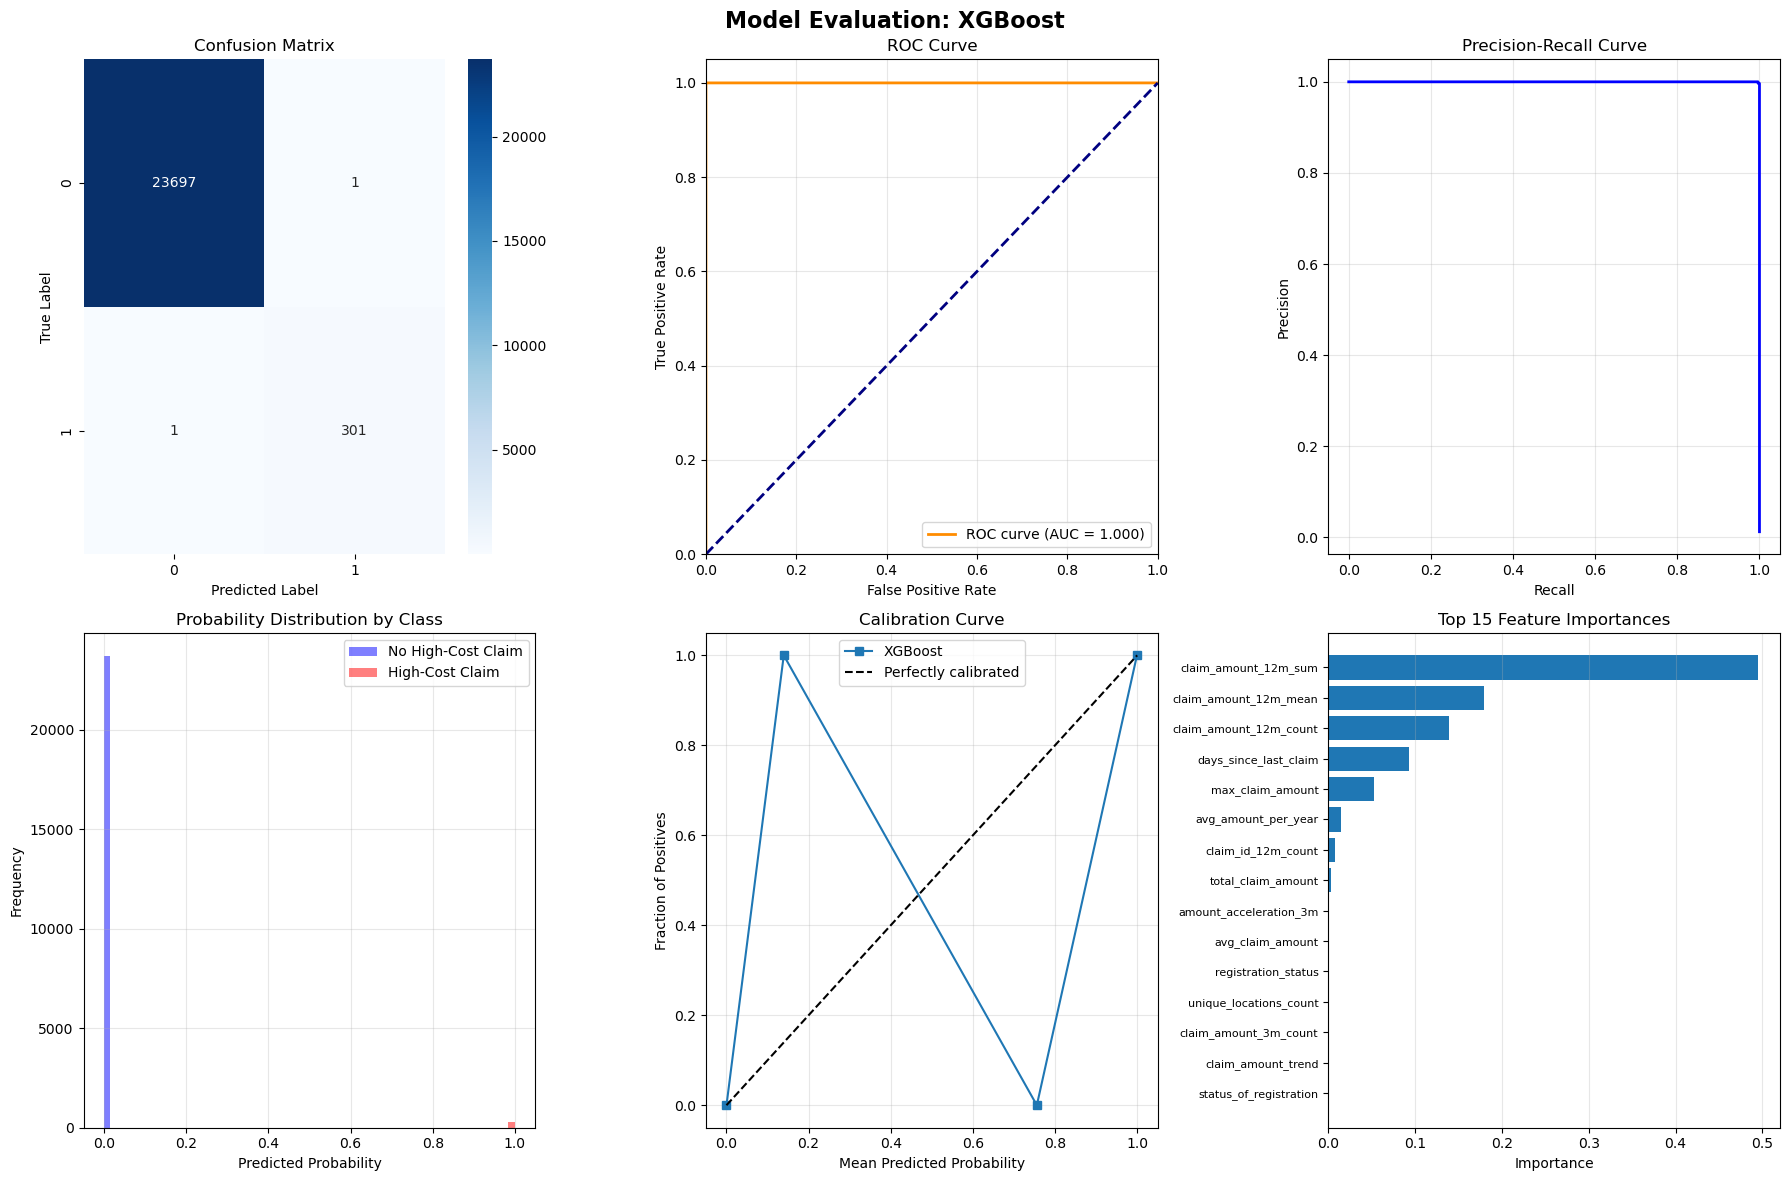


DETAILED CLASSIFICATION REPORT: XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23698
           1       1.00      1.00      1.00       302

    accuracy                           1.00     24000
   macro avg       1.00      1.00      1.00     24000
weighted avg       1.00      1.00      1.00     24000



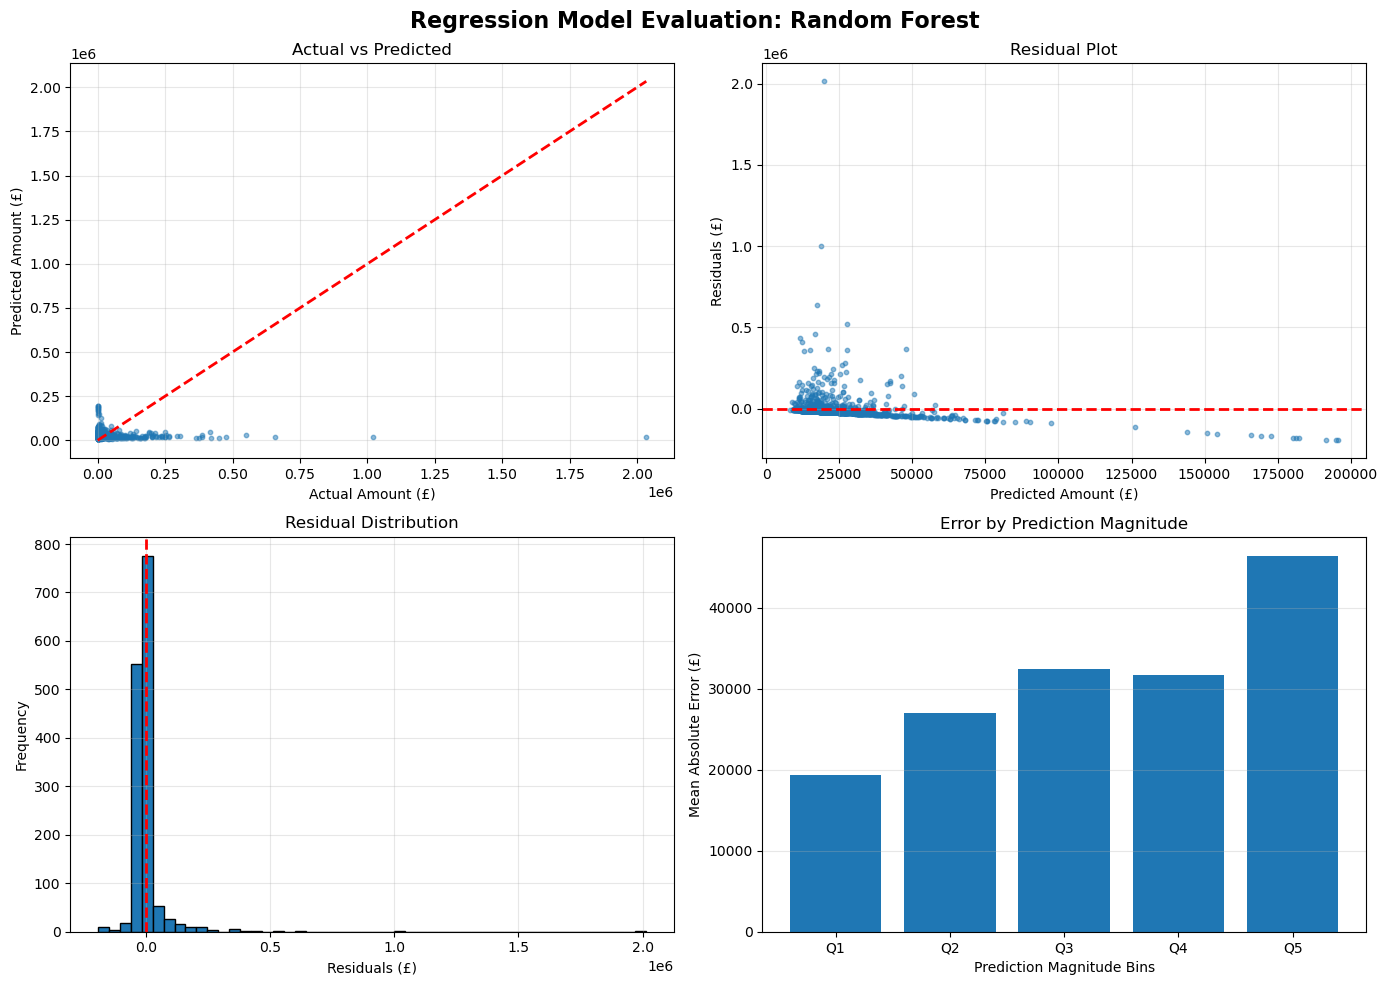

In [28]:
def plot_model_evaluation(y_test, results, model_name):
    """
    Comprehensive model evaluation plots
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Model Evaluation: {model_name}', fontsize=16, fontweight='bold')
    
    y_pred = results['predictions']
    y_proba = results['probabilities']
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
    axes[0, 0].set_title('Confusion Matrix')
    axes[0, 0].set_ylabel('True Label')
    axes[0, 0].set_xlabel('Predicted Label')
    
    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0, 1].set_xlim([0.0, 1.0])
    axes[0, 1].set_ylim([0.0, 1.05])
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC Curve')
    axes[0, 1].legend(loc="lower right")
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    axes[0, 2].plot(recall, precision, color='blue', lw=2)
    axes[0, 2].set_xlabel('Recall')
    axes[0, 2].set_ylabel('Precision')
    axes[0, 2].set_title('Precision-Recall Curve')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Probability Distribution
    axes[1, 0].hist(y_proba[y_test == 0], bins=50, alpha=0.5, label='No High-Cost Claim', color='blue')
    axes[1, 0].hist(y_proba[y_test == 1], bins=50, alpha=0.5, label='High-Cost Claim', color='red')
    axes[1, 0].set_xlabel('Predicted Probability')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Probability Distribution by Class')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Calibration Curve
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_proba, n_bins=10)
    axes[1, 1].plot(mean_predicted_value, fraction_of_positives, "s-", label=model_name)
    axes[1, 1].plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
    axes[1, 1].set_xlabel('Mean Predicted Probability')
    axes[1, 1].set_ylabel('Fraction of Positives')
    axes[1, 1].set_title('Calibration Curve')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Feature Importance (if available)
    if 'feature_importance' in results:
        top_features = results['feature_importance'].head(15)
        axes[1, 2].barh(range(len(top_features)), top_features['importance'])
        axes[1, 2].set_yticks(range(len(top_features)))
        axes[1, 2].set_yticklabels(top_features['feature'], fontsize=8)
        axes[1, 2].set_xlabel('Importance')
        axes[1, 2].set_title('Top 15 Feature Importances')
        axes[1, 2].invert_yaxis()
        axes[1, 2].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed classification report
    print("\n" + "="*80)
    print(f"DETAILED CLASSIFICATION REPORT: {model_name}")
    print("="*80)
    print(results['classification_report'])


def plot_regression_evaluation(y_test, y_pred, model_name):
    """
    Regression model evaluation plots
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Regression Model Evaluation: {model_name}', fontsize=16, fontweight='bold')
    
    # 1. Actual vs Predicted
    axes[0, 0].scatter(y_test, y_pred, alpha=0.5, s=10)
    axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0, 0].set_xlabel('Actual Amount (£)')
    axes[0, 0].set_ylabel('Predicted Amount (£)')
    axes[0, 0].set_title('Actual vs Predicted')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Residuals
    residuals = y_test - y_pred
    axes[0, 1].scatter(y_pred, residuals, alpha=0.5, s=10)
    axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[0, 1].set_xlabel('Predicted Amount (£)')
    axes[0, 1].set_ylabel('Residuals (£)')
    axes[0, 1].set_title('Residual Plot')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Residual Distribution
    axes[1, 0].hist(residuals, bins=50, edgecolor='black')
    axes[1, 0].set_xlabel('Residuals (£)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Residual Distribution')
    axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Error Distribution by Prediction Magnitude
    pred_bins = pd.qcut(y_pred, q=5, duplicates='drop')
    error_by_bin = pd.DataFrame({
        'bin': pred_bins,
        'error': np.abs(residuals)
    }).groupby('bin')['error'].mean()
    
    axes[1, 1].bar(range(len(error_by_bin)), error_by_bin.values)
    axes[1, 1].set_xlabel('Prediction Magnitude Bins')
    axes[1, 1].set_ylabel('Mean Absolute Error (£)')
    axes[1, 1].set_title('Error by Prediction Magnitude')
    axes[1, 1].set_xticks(range(len(error_by_bin)))
    axes[1, 1].set_xticklabels([f'Q{i+1}' for i in range(len(error_by_bin))], rotation=0)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


# Generate evaluation plots
plot_model_evaluation(
    y_test_class, 
    classification_results[best_classification_model],
    best_classification_model
)

# For regression (only non-zero claims)
test_mask = y_test_reg > 0
plot_regression_evaluation(
    y_test_reg[test_mask],
    regression_results[best_regression_model]['predictions'],
    best_regression_model
)

#### 6. RISK STRATIFICATION & PREDICTION PIPELINE

In [31]:
def create_risk_stratification(dataset, classification_model, regression_model, X_features):
    """
    Create comprehensive risk stratification for all members
    """
    import numpy as np
    import pandas as pd

    print("\n" + "="*80)
    print("CREATING RISK STRATIFICATION")
    print("="*80)

    # --- Defensive checks ---
    dataset = dataset.reset_index(drop=True)
    X_features = X_features.reset_index(drop=True)

    if hasattr(classification_model, "n_features_in_") and X_features.shape[1] != classification_model.n_features_in_:
        raise ValueError(
            f"❌ Feature mismatch: classification_model expects {classification_model.n_features_in_} features, "
            f"but X_features has {X_features.shape[1]}"
        )

    if hasattr(regression_model, "n_features_in_") and X_features.shape[1] != regression_model.n_features_in_:
        raise ValueError(
            f"❌ Feature mismatch: regression_model expects {regression_model.n_features_in_} features, "
            f"but X_features has {X_features.shape[1]}"
        )

    # --- Predict ---
    print("Predicting probabilities and amounts...")
    high_cost_proba = classification_model.predict_proba(X_features)[:, 1]
    predicted_amount = regression_model.predict(X_features)
    predicted_amount = np.maximum(predicted_amount, 0)  # No negative predictions

    # --- Align lengths (handle mismatched shapes safely) ---
    n = min(len(dataset), len(predicted_amount))
    dataset = dataset.iloc[:n].copy()
    high_cost_proba = high_cost_proba[:n]
    predicted_amount = predicted_amount[:n]

    result_df = dataset.copy()
    result_df['predicted_high_cost_probability'] = high_cost_proba
    result_df['predicted_total_amount'] = predicted_amount

    # --- Risk tiers ---
    result_df['risk_tier_probability'] = pd.cut(
        high_cost_proba,
        bins=[0, 0.3, 0.6, 1.0],
        labels=['Low', 'Medium', 'High']
    )

    result_df['risk_tier_amount'] = pd.cut(
        predicted_amount,
        bins=[
            -np.inf,
            np.percentile(predicted_amount, 33),
            np.percentile(predicted_amount, 67),
            np.inf
        ],
        labels=['Low', 'Medium', 'High']
    )

    # --- Combined risk score ---
    if predicted_amount.max() == predicted_amount.min():
        amount_score = np.zeros_like(predicted_amount)
    else:
        amount_score = (predicted_amount - predicted_amount.min()) / (
            predicted_amount.max() - predicted_amount.min()
        ) * 100

    prob_score = high_cost_proba * 100
    result_df['combined_risk_score'] = 0.6 * prob_score + 0.4 * amount_score

    result_df['final_risk_category'] = pd.cut(
        result_df['combined_risk_score'],
        bins=[0, 33, 66, 100],
        labels=['Low Risk', 'Medium Risk', 'High Risk']
    )

    # --- Detailed risk segments ---
    result_df['risk_segment'] = 'Standard'
    result_df.loc[
        (result_df['predicted_high_cost_probability'] > 0.7)
        & (result_df['predicted_total_amount'] > result_df['predicted_total_amount'].quantile(0.75)),
        'risk_segment'
    ] = 'Critical - High Probability & High Amount'

    result_df.loc[
        (result_df['predicted_high_cost_probability'] > 0.7)
        & (result_df['predicted_total_amount'] <= result_df['predicted_total_amount'].quantile(0.75)),
        'risk_segment'
    ] = 'High Probability - Moderate Amount'

    result_df.loc[
        (result_df['predicted_high_cost_probability'] <= 0.7)
        & (result_df['predicted_total_amount'] > result_df['predicted_total_amount'].quantile(0.75)),
        'risk_segment'
    ] = 'Moderate Probability - High Amount'

    result_df.loc[
        result_df['predicted_high_cost_probability'] < 0.3,
        'risk_segment'
    ] = 'Low Risk'

    # --- Summary ---
    print("\n1. RISK DISTRIBUTION:")
    print(result_df['final_risk_category'].value_counts(dropna=False))
    print("\nRisk Segments:")
    print(result_df['risk_segment'].value_counts(dropna=False))

    print("\n2. FINANCIAL PROJECTIONS:")
    print(f"Total Predicted Claim Amount: £{result_df['predicted_total_amount'].sum():,.2f}")
    print(f"Average Per Member: £{result_df['predicted_total_amount'].mean():,.2f}")
    print(f"Median Per Member: £{result_df['predicted_total_amount'].median():,.2f}")

    print("\n3. HIGH-RISK MEMBERS:")
    high_risk_count = (result_df['final_risk_category'] == 'High Risk').sum()
    high_risk_pct = high_risk_count / len(result_df) * 100
    high_risk_amount = result_df.loc[result_df['final_risk_category'] == 'High Risk', 'predicted_total_amount'].sum()
    high_risk_amount_pct = high_risk_amount / result_df['predicted_total_amount'].sum() * 100
    print(f"High-Risk Members: {high_risk_count:,} ({high_risk_pct:.1f}%)")
    print(f"Predicted Amount for High-Risk: £{high_risk_amount:,.2f} ({high_risk_amount_pct:.1f}% of total)")

    print("\n4. BREAKDOWN BY RISK CATEGORY:")
    risk_summary = result_df.groupby('final_risk_category', dropna=False).agg({
        'predicted_total_amount': ['count', 'sum', 'mean', 'median'],
        'predicted_high_cost_probability': 'mean'
    }).round(2)
    print(risk_summary)

    print("\n✅ Risk stratification completed successfully!")
    return result_df



def generate_member_predictions(member_id, risk_stratified_df):
    """
    Generate detailed prediction for a specific member
    """
    
    member_data = risk_stratified_df[risk_stratified_df['unique_id'] == member_id]
    
    if len(member_data) == 0:
        member_data = risk_stratified_df[risk_stratified_df['claimant_unique_id'] == member_id]
    
    if len(member_data) == 0:
        print(f"Member {member_id} not found!")
        return None
    
    member = member_data.iloc[0]
    
    print("\n" + "="*80)
    print(f"PREDICTION REPORT FOR MEMBER: {member_id}")
    print("="*80)
    
    print("\n1. DEMOGRAPHIC INFORMATION:")
    print(f"   Age: {member.get('current_age', 'N/A')}")
    print(f"   Gender: {member.get('gender', 'N/A')}")
    print(f"   Membership Tenure: {member.get('membership_tenure_years', 0):.1f} years")
    
    print("\n2. CLAIMS HISTORY:")
    print(f"   Total Historical Claims: {member.get('total_claims', 0):.0f}")
    print(f"   Total Historical Amount: £{member.get('total_claim_amount', 0):,.2f}")
    print(f"   Average Claim Amount: £{member.get('avg_claim_amount', 0):,.2f}")
    print(f"   Claims in Last 12 Months: {member.get('claim_amount_12m_count', 0):.0f}")
    print(f"   Amount in Last 12 Months: £{member.get('claim_amount_12m_sum', 0):,.2f}")
    
    print("\n3. RISK ASSESSMENT:")
    print(f"   Risk Category: {member['final_risk_category']}")
    print(f"   Risk Segment: {member['risk_segment']}")
    print(f"   Combined Risk Score: {member['combined_risk_score']:.1f}/100")
    print(f"   High-Cost Claim Probability: {member['predicted_high_cost_probability']:.1%}")
    
    print("\n4. 12-MONTH PREDICTION:")
    print(f"   Predicted Total Claim Amount: £{member['predicted_total_amount']:,.2f}")
    
    confidence_level = "High" if member['predicted_high_cost_probability'] > 0.7 else "Medium" if member['predicted_high_cost_probability'] > 0.3 else "Low"
    print(f"   Confidence Level: {confidence_level}")
    
    print("\n5. RECOMMENDATIONS:")
    if member['final_risk_category'] == 'High Risk':
        print("   • Priority member for case management")
        print("   • Consider pre-authorization for expensive procedures")
        print("   • Implement preventive care programs")
        print("   • Regular health monitoring recommended")
    elif member['final_risk_category'] == 'Medium Risk':
        print("   • Monitor claims activity")
        print("   • Encourage preventive health measures")
        print("   • Standard case management protocols")
    else:
        print("   • Standard monitoring")
        print("   • Encourage continued healthy lifestyle")
    
    return member


# Create risk stratification
risk_stratified_members = create_risk_stratification(
    modeling_dataset,
    classification_models[best_classification_model],
    regression_models[best_regression_model],
    X_test
)


CREATING RISK STRATIFICATION
Predicting probabilities and amounts...

1. RISK DISTRIBUTION:
final_risk_category
Low Risk       23577
Medium Risk      339
High Risk         84
Name: count, dtype: int64

Risk Segments:
risk_segment
Low Risk                                     23698
Critical - High Probability & High Amount      211
High Probability - Moderate Amount              91
Name: count, dtype: int64

2. FINANCIAL PROJECTIONS:
Total Predicted Claim Amount: £603,044,981.28
Average Per Member: £25,126.87
Median Per Member: £20,104.00

3. HIGH-RISK MEMBERS:
High-Risk Members: 84 (0.4%)
Predicted Amount for High-Risk: £5,846,963.55 (1.0% of total)

4. BREAKDOWN BY RISK CATEGORY:
                    predicted_total_amount                                    \
                                     count           sum      mean    median   
final_risk_category                                                            
Low Risk                             23577  5.681124e+08  24096.04  19


                              EXECUTIVE SUMMARY
                    PREDICTIVE ANALYTICS FOR COST SUSTAINABILITY

Analysis Date: 2024-11-10
Prediction Horizon: 12 months
Total Members Analyzed: 24,000

----------------------------------------------------------------------------------------------------
KEY FINANCIAL PROJECTIONS
----------------------------------------------------------------------------------------------------

1. OVERALL PROJECTIONS:
   Total Predicted Claims Amount: £603,044,981.28
   Expected Number of Claimants: 24,000 (100.0% of members)
   Average Per Member (All): £25,126.87
   Average Per Claimant: £25,126.87

2. RISK DISTRIBUTION:

   Low Risk:
   - Members: 23,577 (98.2%)
   - Predicted Amount: £568,112,366.02 (94.2% of total)
   - Average Per Member: £24,096.04

   Medium Risk:
   - Members: 339 (1.4%)
   - Predicted Amount: £29,085,651.71 (4.8% of total)
   - Average Per Member: £85,798.38

   High Risk:
   - Members: 84 (0.4%)
   - Predicted Amount: £5,846

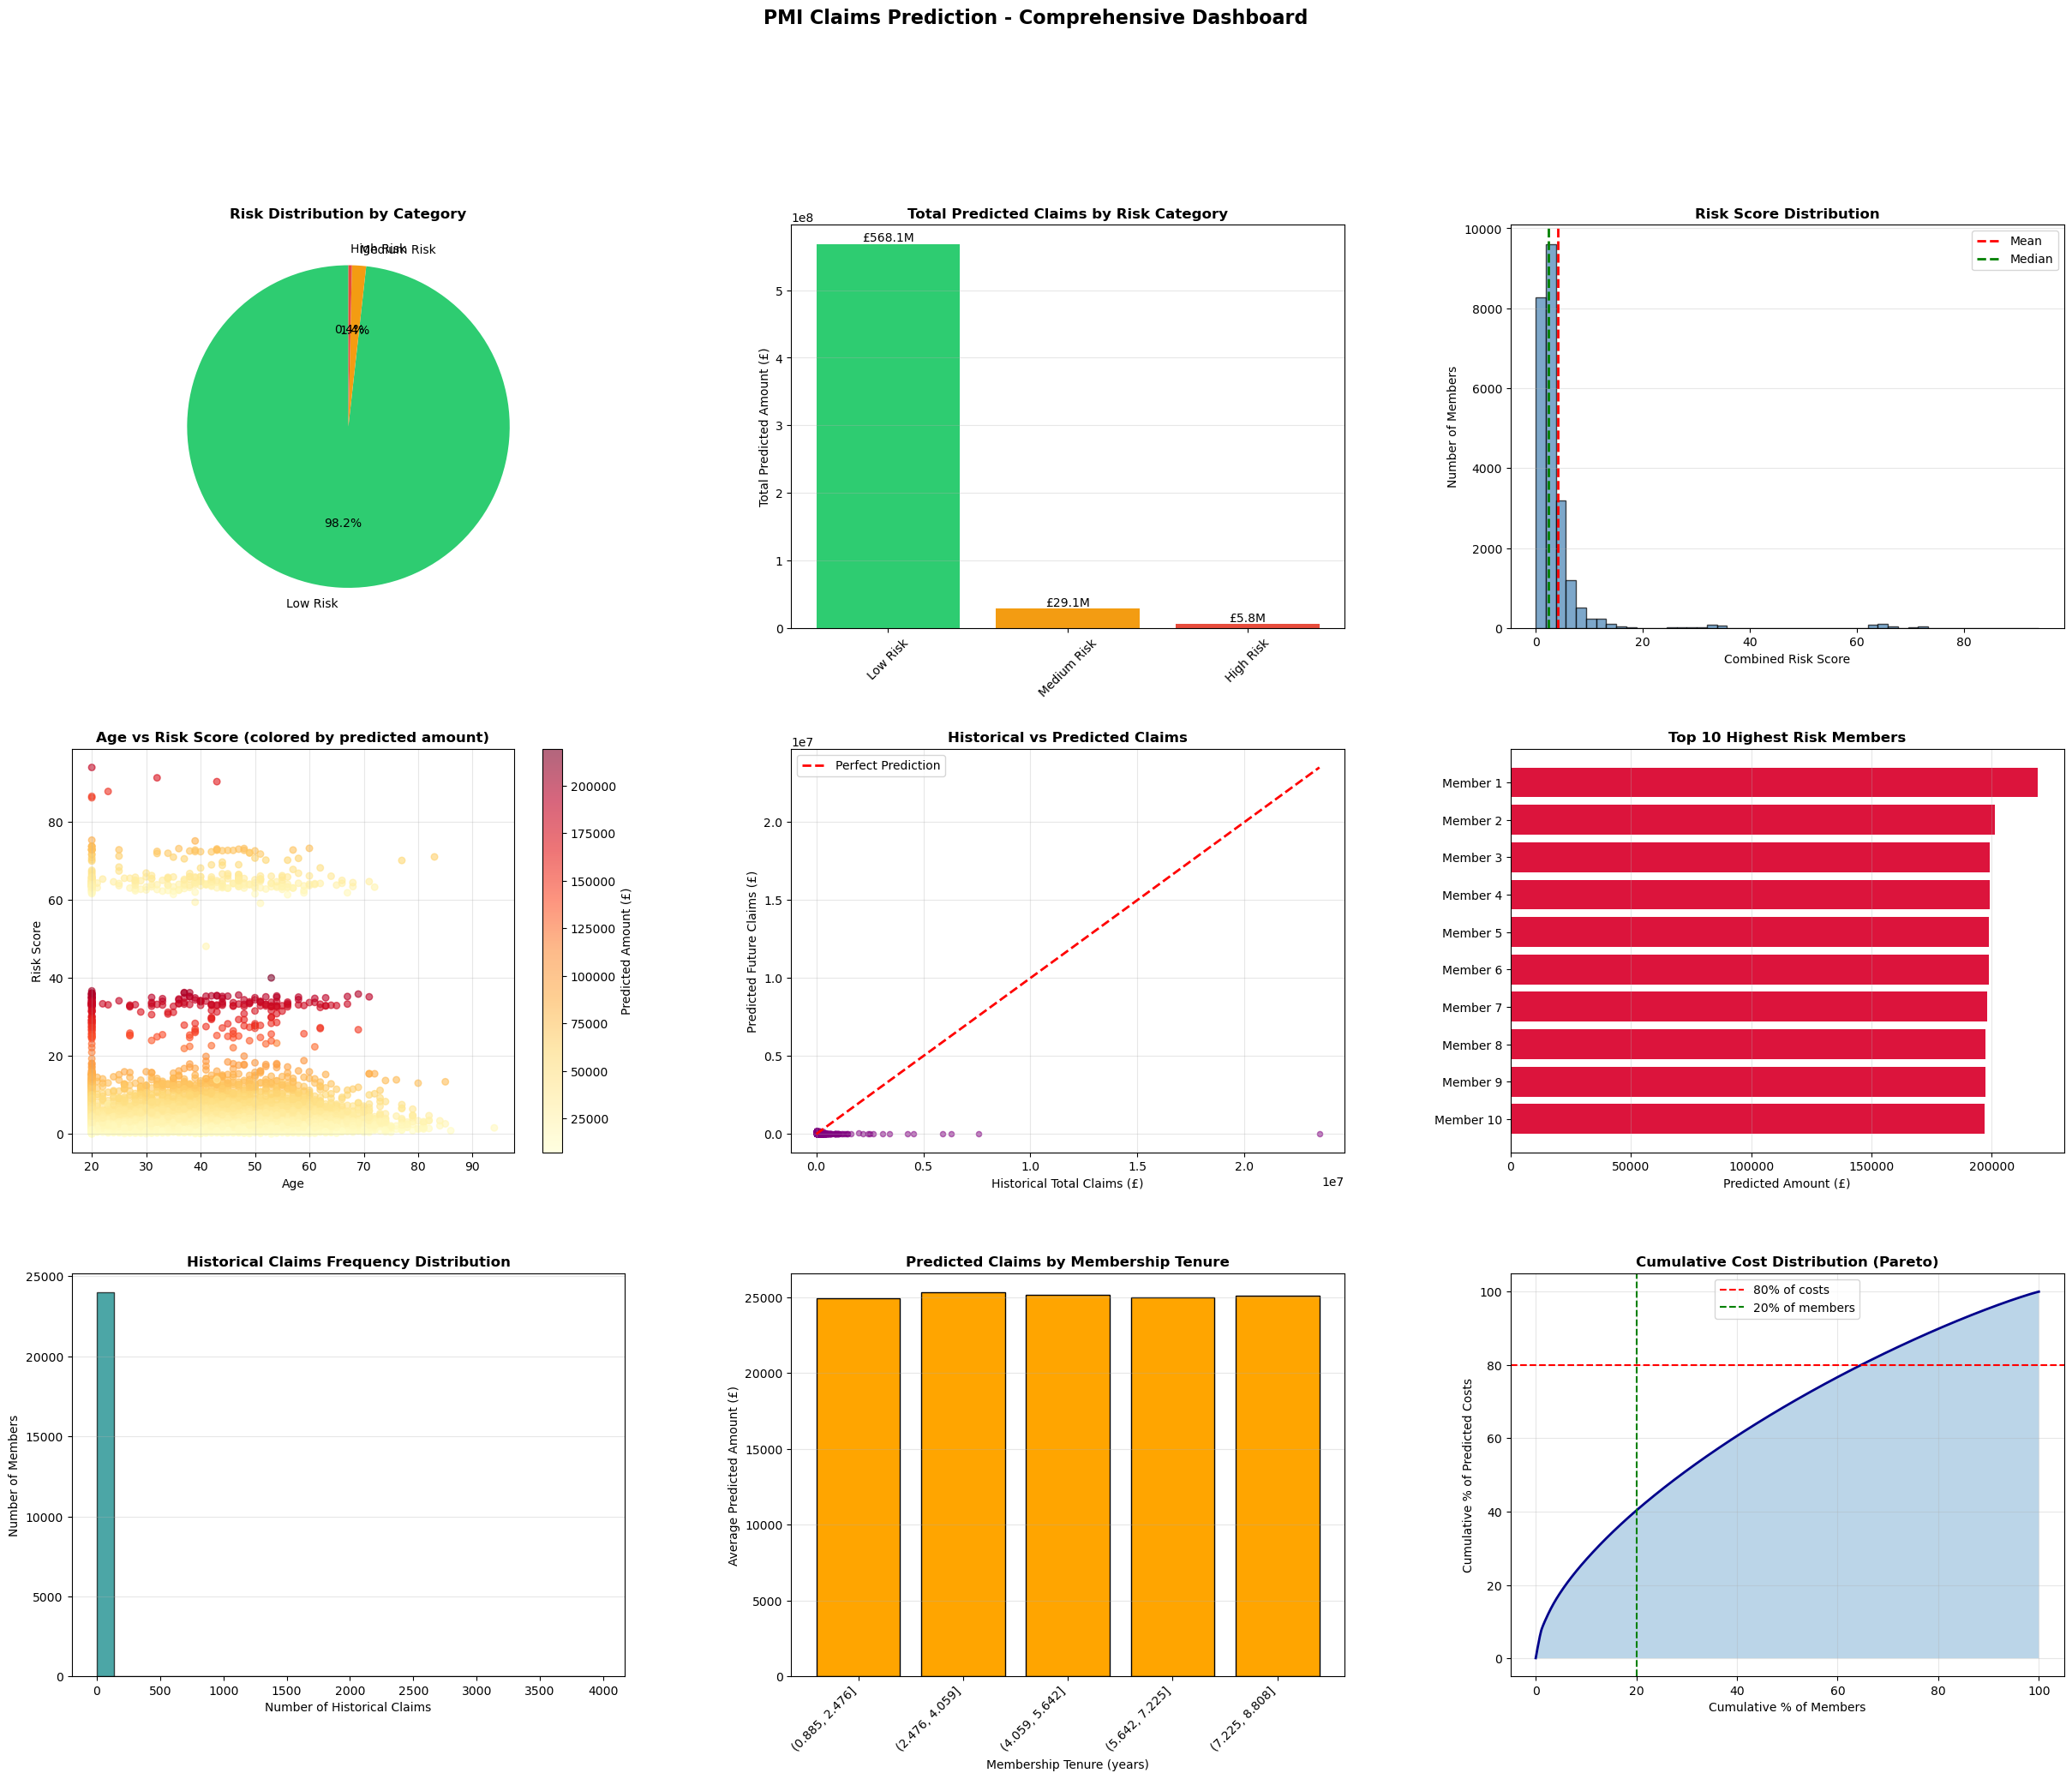

In [33]:
def generate_executive_summary(risk_stratified_df, observation_date, prediction_horizon_months=12):
    """
    Generate executive summary for stakeholders
    """
    
    print("\n" + "="*100)
    print(" " * 30 + "EXECUTIVE SUMMARY")
    print(" " * 20 + "PREDICTIVE ANALYTICS FOR COST SUSTAINABILITY")
    print("="*100)
    
    print(f"\nAnalysis Date: {observation_date.date()}")
    print(f"Prediction Horizon: {prediction_horizon_months} months")
    print(f"Total Members Analyzed: {len(risk_stratified_df):,}")
    
    # Key Metrics
    print("\n" + "-"*100)
    print("KEY FINANCIAL PROJECTIONS")
    print("-"*100)
    
    total_predicted = risk_stratified_df['predicted_total_amount'].sum()
    members_with_claims = (risk_stratified_df['predicted_total_amount'] > 0).sum()
    avg_per_member = total_predicted / len(risk_stratified_df)
    avg_per_claimant = total_predicted / members_with_claims if members_with_claims > 0 else 0
    
    print(f"\n1. OVERALL PROJECTIONS:")
    print(f"   Total Predicted Claims Amount: £{total_predicted:,.2f}")
    print(f"   Expected Number of Claimants: {members_with_claims:,} ({members_with_claims/len(risk_stratified_df)*100:.1f}% of members)")
    print(f"   Average Per Member (All): £{avg_per_member:,.2f}")
    print(f"   Average Per Claimant: £{avg_per_claimant:,.2f}")
    
    # Risk Distribution
    print(f"\n2. RISK DISTRIBUTION:")
    
    for risk_cat in ['Low Risk', 'Medium Risk', 'High Risk']:
        risk_df = risk_stratified_df[risk_stratified_df['final_risk_category'] == risk_cat]
        count = len(risk_df)
        pct = count / len(risk_stratified_df) * 100
        amount = risk_df['predicted_total_amount'].sum()
        amount_pct = amount / total_predicted * 100 if total_predicted > 0 else 0
        
        print(f"\n   {risk_cat}:")
        print(f"   - Members: {count:,} ({pct:.1f}%)")
        print(f"   - Predicted Amount: £{amount:,.2f} ({amount_pct:.1f}% of total)")
        print(f"   - Average Per Member: £{amount/count:,.2f}")
    
    # High-Cost Claims
    print(f"\n3. HIGH-COST CLAIMS PROJECTION:")
    
    high_prob_members = risk_stratified_df[risk_stratified_df['predicted_high_cost_probability'] > 0.5]
    high_prob_count = len(high_prob_members)
    high_prob_amount = high_prob_members['predicted_total_amount'].sum()
    
    print(f"   Members Likely to Have High-Cost Claims: {high_prob_count:,} ({high_prob_count/len(risk_stratified_df)*100:.1f}%)")
    print(f"   Projected Amount for High-Cost Members: £{high_prob_amount:,.2f} ({high_prob_amount/total_predicted*100:.1f}% of total)")
    print(f"   Average Per High-Risk Member: £{high_prob_amount/high_prob_count:,.2f}" if high_prob_count > 0 else "   Average: N/A")
    
    # Top Drivers
    print(f"\n4. KEY RISK FACTORS (Most Important Predictors):")
    
    # Age-based
    age_high_risk = risk_stratified_df[risk_stratified_df['final_risk_category'] == 'High Risk']['current_age'].mean()
    age_overall = risk_stratified_df['current_age'].mean()
    print(f"   - Average Age of High-Risk Members: {age_high_risk:.1f} years (vs {age_overall:.1f} overall)")
    
    # Historical claims
    hist_high_risk = risk_stratified_df[risk_stratified_df['final_risk_category'] == 'High Risk']['total_claims'].mean()
    hist_overall = risk_stratified_df['total_claims'].mean()
    print(f"   - Average Historical Claims (High-Risk): {hist_high_risk:.1f} (vs {hist_overall:.1f} overall)")
    
    # Chronic conditions
    chronic_high_risk = risk_stratified_df[risk_stratified_df['final_risk_category'] == 'High Risk']['chronic_condition_claims'].mean()
    chronic_overall = risk_stratified_df['chronic_condition_claims'].mean()
    print(f"   - Average Chronic Condition Claims (High-Risk): {chronic_high_risk:.1f} (vs {chronic_overall:.1f} overall)")
    
    # Strategic Recommendations
    print("\n" + "-"*100)
    print("STRATEGIC RECOMMENDATIONS")
    print("-"*100)
    
    # Calculate potential savings
    high_risk_members = risk_stratified_df[risk_stratified_df['final_risk_category'] == 'High Risk']
    potential_intervention_savings = high_risk_members['predicted_total_amount'].sum() * 0.15  # Assume 15% reduction
    
    print(f"\n1. PROACTIVE CASE MANAGEMENT:")
    print(f"   - Focus on {len(high_risk_members):,} high-risk members")
    print(f"   - Potential savings with 15% cost reduction: £{potential_intervention_savings:,.2f}")
    print(f"   - Implement disease management programs for chronic conditions")
    
    print(f"\n2. INSURANCE NEGOTIATIONS:")
    print(f"   - Total expected claims: £{total_predicted:,.2f}")
    print(f"   - High-cost exposure (top 20%): £{risk_stratified_df.nlargest(int(len(risk_stratified_df)*0.2), 'predicted_total_amount')['predicted_total_amount'].sum():,.2f}")
    print(f"   - Consider stop-loss insurance for claims above £{risk_stratified_df['predicted_total_amount'].quantile(0.95):,.2f}")
    
    print(f"\n3. RISK MITIGATION STRATEGIES:")
    print(f"   - Implement wellness programs targeting high-risk segments")
    print(f"   - Pre-authorization for procedures estimated above £{risk_stratified_df['predicted_total_amount'].quantile(0.90):,.2f}")
    print(f"   - Telemedicine and preventive care for medium-risk members")
    
    print(f"\n4. FINANCIAL PLANNING:")
    confidence_interval = total_predicted * 0.15  # ±15% confidence
    print(f"   - Budget Range: £{total_predicted - confidence_interval:,.2f} - £{total_predicted + confidence_interval:,.2f}")
    print(f"   - Reserve Requirement: £{total_predicted * 0.20:,.2f} (20% buffer)")
    print(f"   - Monthly Accrual: £{total_predicted / 12:,.2f}")
    
    print("\n" + "="*100)


def create_risk_segments_analysis(risk_stratified_df):
    """
    Detailed analysis by risk segments
    """
    
    print("\n" + "="*80)
    print("DETAILED RISK SEGMENT ANALYSIS")
    print("="*80)
    
    segments = risk_stratified_df['risk_segment'].unique()
    
    for segment in segments:
        segment_df = risk_stratified_df[risk_stratified_df['risk_segment'] == segment]
        
        print(f"\n{'-'*80}")
        print(f"SEGMENT: {segment}")
        print(f"{'-'*80}")
        
        print(f"\nPopulation: {len(segment_df):,} members ({len(segment_df)/len(risk_stratified_df)*100:.1f}%)")
        
        print(f"\nFinancial Metrics:")
        print(f"  - Total Predicted Amount: £{segment_df['predicted_total_amount'].sum():,.2f}")
        print(f"  - Average Per Member: £{segment_df['predicted_total_amount'].mean():,.2f}")
        print(f"  - Median Per Member: £{segment_df['predicted_total_amount'].median():,.2f}")
        print(f"  - Std Dev: £{segment_df['predicted_total_amount'].std():,.2f}")
        
        print(f"\nDemographic Profile:")
        print(f"  - Average Age: {segment_df['current_age'].mean():.1f} years")
        print(f"  - Gender Distribution: {segment_df['gender'].value_counts().to_dict()}")
        print(f"  - Average Tenure: {segment_df['membership_tenure_years'].mean():.1f} years")
        
        print(f"\nClaims History:")
        print(f"  - Avg Total Historical Claims: {segment_df['total_claims'].mean():.1f}")
        print(f"  - Avg Claims Last 12M: {segment_df['claim_amount_12m_count'].mean():.1f}")
        print(f"  - % with Chronic Conditions: {(segment_df['chronic_condition_claims'] > 0).sum() / len(segment_df) * 100:.1f}%")
        
        print(f"\nRisk Metrics:")
        print(f"  - Average High-Cost Probability: {segment_df['predicted_high_cost_probability'].mean():.1%}")
        print(f"  - Average Risk Score: {segment_df['combined_risk_score'].mean():.1f}/100")


def export_member_risk_list(risk_stratified_df, output_file='member_risk_stratification.csv'):
    """
    Export member-level predictions for operational use
    """
    
    # Select key columns for export
    export_columns = [
        'unique_id', 'claimant_unique_id',
        'current_age', 'gender', 'membership_tenure_years',
        'total_claims', 'total_claim_amount',
        'claim_amount_12m_count', 'claim_amount_12m_sum',
        'predicted_high_cost_probability',
        'predicted_total_amount',
        'combined_risk_score',
        'final_risk_category',
        'risk_segment'
    ]
    
    # Filter columns that exist
    export_columns = [col for col in export_columns if col in risk_stratified_df.columns]
    
    export_df = risk_stratified_df[export_columns].copy()
    
    # Sort by risk score
    export_df = export_df.sort_values('combined_risk_score', ascending=False)
    
    # Save to CSV
    export_df.to_csv(output_file, index=False)
    
    print(f"\n✓ Member risk stratification exported to: {output_file}")
    print(f"  Total members: {len(export_df):,}")
    print(f"  Columns: {len(export_df.columns)}")
    
    return export_df


def create_visualization_dashboard(risk_stratified_df):
    """
    Create comprehensive visualization dashboard
    """
    
    fig = plt.figure(figsize=(30, 22))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Risk Distribution Pie Chart
    ax1 = fig.add_subplot(gs[0, 0])
    risk_counts = risk_stratified_df['final_risk_category'].value_counts()
    colors = ['#2ecc71', '#f39c12', '#e74c3c']
    ax1.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90)
    ax1.set_title('Risk Distribution by Category', fontweight='bold', fontsize=12)
    
    # 2. Predicted Amount by Risk Category
    ax2 = fig.add_subplot(gs[0, 1])
    risk_amounts = risk_stratified_df.groupby('final_risk_category')['predicted_total_amount'].sum()
    ax2.bar(risk_amounts.index, risk_amounts.values, color=colors)
    ax2.set_ylabel('Total Predicted Amount (£)')
    ax2.set_title('Total Predicted Claims by Risk Category', fontweight='bold', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    for i, v in enumerate(risk_amounts.values):
        ax2.text(i, v, f'£{v/1e6:.1f}M', ha='center', va='bottom')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Risk Score Distribution
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.hist(risk_stratified_df['combined_risk_score'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    ax3.axvline(risk_stratified_df['combined_risk_score'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    ax3.axvline(risk_stratified_df['combined_risk_score'].median(), color='green', linestyle='--', linewidth=2, label='Median')
    ax3.set_xlabel('Combined Risk Score')
    ax3.set_ylabel('Number of Members')
    ax3.set_title('Risk Score Distribution', fontweight='bold', fontsize=12)
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Age vs Risk Score
    ax4 = fig.add_subplot(gs[1, 0])
    scatter = ax4.scatter(risk_stratified_df['current_age'], 
                         risk_stratified_df['combined_risk_score'],
                         c=risk_stratified_df['predicted_total_amount'],
                         cmap='YlOrRd', alpha=0.6, s=30)
    ax4.set_xlabel('Age')
    ax4.set_ylabel('Risk Score')
    ax4.set_title('Age vs Risk Score (colored by predicted amount)', fontweight='bold', fontsize=12)
    plt.colorbar(scatter, ax=ax4, label='Predicted Amount (£)')
    ax4.grid(True, alpha=0.3)
    
    # 5. Historical vs Predicted Claims
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.scatter(risk_stratified_df['total_claim_amount'], 
               risk_stratified_df['predicted_total_amount'],
               alpha=0.5, s=20, color='purple')
    ax5.plot([0, risk_stratified_df['total_claim_amount'].max()], 
            [0, risk_stratified_df['total_claim_amount'].max()], 
            'r--', lw=2, label='Perfect Prediction')
    ax5.set_xlabel('Historical Total Claims (£)')
    ax5.set_ylabel('Predicted Future Claims (£)')
    ax5.set_title('Historical vs Predicted Claims', fontweight='bold', fontsize=12)
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Top 10 High-Risk Members
    ax6 = fig.add_subplot(gs[1, 2])
    top_10 = risk_stratified_df.nlargest(10, 'predicted_total_amount')
    ax6.barh(range(10), top_10['predicted_total_amount'].values, color='crimson')
    ax6.set_yticks(range(10))
    ax6.set_yticklabels([f"Member {i+1}" for i in range(10)])
    ax6.set_xlabel('Predicted Amount (£)')
    ax6.set_title('Top 10 Highest Risk Members', fontweight='bold', fontsize=12)
    ax6.invert_yaxis()
    ax6.grid(True, alpha=0.3, axis='x')
    
    # 7. Claims Frequency Distribution
    ax7 = fig.add_subplot(gs[2, 0])
    ax7.hist(risk_stratified_df['total_claims'], bins=30, color='teal', edgecolor='black', alpha=0.7)
    ax7.set_xlabel('Number of Historical Claims')
    ax7.set_ylabel('Number of Members')
    ax7.set_title('Historical Claims Frequency Distribution', fontweight='bold', fontsize=12)
    ax7.grid(True, alpha=0.3, axis='y')
    
    # 8. Tenure vs Predicted Amount
    ax8 = fig.add_subplot(gs[2, 1])
    tenure_bins = pd.cut(risk_stratified_df['membership_tenure_years'], bins=5)
    tenure_avg = risk_stratified_df.groupby(tenure_bins)['predicted_total_amount'].mean()
    ax8.bar(range(len(tenure_avg)), tenure_avg.values, color='orange', edgecolor='black')
    ax8.set_xticks(range(len(tenure_avg)))
    ax8.set_xticklabels([str(x) for x in tenure_avg.index], rotation=45, ha='right')
    ax8.set_ylabel('Average Predicted Amount (£)')
    ax8.set_xlabel('Membership Tenure (years)')
    ax8.set_title('Predicted Claims by Membership Tenure', fontweight='bold', fontsize=12)
    ax8.grid(True, alpha=0.3, axis='y')
    
    # 9. Cumulative Risk Curve (Pareto)
    ax9 = fig.add_subplot(gs[2, 2])
    sorted_amounts = risk_stratified_df['predicted_total_amount'].sort_values(ascending=False)
    cumsum = sorted_amounts.cumsum()
    cumsum_pct = cumsum / cumsum.iloc[-1] * 100
    member_pct = np.arange(1, len(cumsum_pct) + 1) / len(cumsum_pct) * 100
    ax9.plot(member_pct, cumsum_pct, linewidth=2, color='darkblue')
    ax9.axhline(y=80, color='red', linestyle='--', label='80% of costs')
    ax9.axvline(x=20, color='green', linestyle='--', label='20% of members')
    ax9.fill_between(member_pct, cumsum_pct, alpha=0.3)
    ax9.set_xlabel('Cumulative % of Members')
    ax9.set_ylabel('Cumulative % of Predicted Costs')
    ax9.set_title('Cumulative Cost Distribution (Pareto)', fontweight='bold', fontsize=12)
    ax9.legend()
    ax9.grid(True, alpha=0.3)
    
    plt.suptitle('PMI Claims Prediction - Comprehensive Dashboard', 
                fontsize=16, fontweight='bold', y=0.995)
    
    plt.show()


# Generate all reports and visualizations
generate_executive_summary(risk_stratified_members, observation_cutoff)
create_risk_segments_analysis(risk_stratified_members)
member_export = export_member_risk_list(risk_stratified_members)
create_visualization_dashboard(risk_stratified_members)


9. MODEL DEPLOYMENT & MONITORING
9.1 Save Models and Artifacts

In [ ]:
def save_production_artifacts(models, modeling_data, predictions_df, high_claim_threshold):
    """
    Save all necessary artifacts for production deployment
    """
    import os
    import json
    
    # Create directory
    os.makedirs('production_models', exist_ok=True)
    
    print("\n" + "="*60)
    print("SAVING PRODUCTION ARTIFACTS")
    print("="*60)
    
    # 1. Save models
    for model_name, model in models.items():
        filepath = f'production_models/{model_name}.pkl'
        joblib.dump(model, filepath)
        print(f"✓ Saved {model_name}")
    
    # 2. Save preprocessing artifacts
    joblib.dump(modeling_data['scaler'], 'production_models/scaler.pkl')
    joblib.dump(modeling_data['label_encoders'], 'production_models/label_encoders.pkl')
    joblib.dump(modeling_data['le_risk'], 'production_models/risk_encoder.pkl')
    print(f"✓ Saved preprocessing artifacts")
    
    # 3. Save feature names
    with open('production_models/feature_names.json', 'w') as f:
        json.dump(modeling_data['feature_names'], f)
    print(f"✓ Saved feature configuration")
    
    # 4. Save model metadata
    metadata = {
        'high_claim_threshold': float(high_claim_threshold),
        'training_date': datetime.now().strftime('%Y-%m-%d'),
        'total_training_samples': len(modeling_data['X_train']),
        'number_of_features': len(modeling_data['feature_names']),
        'model_versions': {
            'regression': 'xgb_regressor',
            'classification': 'xgb_classifier',
            'stratification': 'xgb_multiclass'
        }
    }
    
    with open('production_models/metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"✓ Saved model metadata")
    
    # 5. Save predictions
    predictions_df.to_csv('production_models/member_predictions.csv', index=False)
    print(f"✓ Saved member predictions")
    
    print(f"\n✓ All artifacts saved to 'production_models/' directory")


save_production_artifacts(all_models, modeling_data, predictions_df, high_claim_threshold)

In [ ]:
def create_prediction_pipeline():
    """
    Create a reusable prediction pipeline for scoring new members
    """
    
    class PMIPredictionPipeline:
        """
        Production-ready prediction pipeline for PMI claims
        """
        
        def __init__(self, model_dir='production_models'):
            """Load all necessary artifacts"""
            self.model_dir = model_dir
            
            # Load models
            self.reg_model = joblib.load(f'{model_dir}/xgb_regressor.pkl')
            self.clf_model = joblib.load(f'{model_dir}/xgb_classifier.pkl')
            self.strat_model = joblib.load(f'{model_dir}/xgb_multiclass.pkl')
            
            # Load preprocessing artifacts
            self.scaler = joblib.load(f'{model_dir}/scaler.pkl')
            self.label_encoders = joblib.load(f'{model_dir}/label_encoders.pkl')
            self.risk_encoder = joblib.load(f'{model_dir}/risk_encoder.pkl')
            
            # Load configuration
            with open(f'{model_dir}/feature_names.json', 'r') as f:
                self.feature_names = json.load(f)
            
            with open(f'{model_dir}/metadata.json', 'r') as f:
                self.metadata = json.load(f)
            
            print("✓ Prediction pipeline loaded successfully")
        
        def preprocess_features(self, features_df):
            """Preprocess features for prediction"""
            X = features_df.copy()
            
            # Ensure all required features exist
            for col in self.feature_names:
                if col not in X.columns:
                    X[col] = 0
            
            # Reorder to match training
            X = X[self.feature_names]
            
            # Encode categorical variables
            for col, encoder in self.label_encoders.items():
                if col in X.columns:
                    X[col] = X[col].astype(str).apply(
                        lambda x: encoder.transform([x])[0] if x in encoder.classes_ else -1
                    )
            
            return X
        
        def predict_single_member(self, member_id, features_df):
            """Generate predictions for a single member"""
            member_data = features_df[features_df['Unique_ID'] == member_id].copy()
            
            if len(member_data) == 0:
                raise ValueError(f"Member ID {member_id} not found")
            
            member_id_val = member_data['Unique_ID'].values[0]
            X = self.preprocess_features(member_data.drop('Unique_ID', axis=1))
            
            predictions = {
                'member_id': member_id_val,
                'predicted_claim_amount': float(self.reg_model.predict(X)[0]),
                'high_claim_probability': float(self.clf_model.predict_proba(X)[0, 1]),
                'will_have_high_claim': bool(self.clf_model.predict(X)[0]),
                'predicted_risk_category': self.risk_encoder.inverse_transform(
                    self.strat_model.predict(X)
                )[0],
                'risk_probabilities': {
                    risk: float(prob) 
                    for risk, prob in zip(
                        self.risk_encoder.classes_,
                        self.strat_model.predict_proba(X)[0]
                    )
                }
            }
            
            return predictions
        
        def predict_batch(self, features_df):
            """Generate predictions for multiple members"""
            member_ids = features_df['Unique_ID'].copy()
            X = self.preprocess_features(features_df.drop('Unique_ID', axis=1))
            
            results = pd.DataFrame({
                'Unique_ID': member_ids,
                'Predicted_Claim_Amount': self.reg_model.predict(X),
                'High_Claim_Probability': self.clf_model.predict_proba(X)[:, 1],
                'Will_Have_High_Claim': self.clf_model.predict(X),
                'Predicted_Risk_Category': self.risk_encoder.inverse_transform(
                    self.strat_model.predict(X)
                )
            })
            
            # Add risk probabilities
            risk_probs = self.strat_model.predict_proba(X)
            for idx, risk_class in enumerate(self.risk_encoder.classes_):
                results[f'Prob_{risk_class}_Risk'] = risk_probs[:, idx]
            
            return results
        
        def get_model_info(self):
            """Return model metadata"""
            return self.metadata
    
    return PMIPredictionPipeline


# Create and test pipeline
PMIPipeline = create_prediction_pipeline()
pipeline = PMIPipeline()

print("\n" + "="*60)
print("TESTING PREDICTION PIPELINE")
print("="*60)

# Test single member prediction
test_member_id = member_features_df['Unique_ID'].iloc[0]
single_pred = pipeline.predict_single_member(test_member_id, member_features_df)
print(f"\nSingle Member Prediction (ID: {test_member_id}):")
for key, value in single_pred.items():
    if key != 'risk_probabilities':
        print(f"  {key}: {value}")

# Test batch prediction
batch_pred = pipeline.predict_batch(member_features_df.head(10))
print(f"\nBatch Prediction Sample:")
print(batch_pred.head())

REVISED: Proper Time-Based Train-Test Split

In [ ]:
def create_time_based_split(claims_df, membership_df, test_months=12, lookback_years=2):
    """
    Create proper time-based train-test split for temporal prediction
    
    Parameters:
    - test_months: How many months ahead to predict (default: 12)
    - lookback_years: Historical period for feature creation (default: 2)
    """
    
    print("\n" + "="*80)
    print("TIME-BASED DATA SPLITTING")
    print("="*80)
    
    # Get the date range of available data
    min_date = claims_df['Incurred_Date'].min()
    max_date = claims_df['Incurred_Date'].max()
    
    print(f"\nData Range: {min_date.date()} to {max_date.date()}")
    print(f"Total months available: {(max_date - min_date).days / 30:.1f}")
    
    # Define observation cutoff (split point)
    # We need: lookback_years for features + test_months for target
    required_months = (lookback_years * 12) + test_months
    
    # Set observation cutoff date (leave last 12 months for testing)
    observation_cutoff = max_date - pd.DateOffset(months=test_months)
    
    # Training observation period ends earlier to allow for target period
    train_observation_cutoff = observation_cutoff - pd.DateOffset(months=test_months)
    
    print(f"\n" + "-"*80)
    print("DATA SPLIT TIMELINE:")
    print("-"*80)
    print(f"│")
    print(f"│  TRAINING SET")
    print(f"│  ├─ Feature Period: {train_observation_cutoff - pd.DateOffset(years=lookback_years)} to {train_observation_cutoff}")
    print(f"│  └─ Target Period:  {train_observation_cutoff} to {train_observation_cutoff + pd.DateOffset(months=test_months)}")
    print(f"│")
    print(f"│  TEST SET")
    print(f"│  ├─ Feature Period: {observation_cutoff - pd.DateOffset(years=lookback_years)} to {observation_cutoff}")
    print(f"│  └─ Target Period:  {observation_cutoff} to {max_date}")
    print(f"│")
    print("-"*80)
    
    # Validate we have enough data
    if (train_observation_cutoff - min_date).days < (lookback_years * 365):
        raise ValueError(f"Insufficient historical data. Need at least {lookback_years} years before train cutoff.")
    
    split_info = {
        'min_date': min_date,
        'max_date': max_date,
        'train_observation_cutoff': train_observation_cutoff,
        'test_observation_cutoff': observation_cutoff,
        'lookback_years': lookback_years,
        'test_months': test_months
    }
    
    return split_info


# Create time-based split
split_info = create_time_based_split(claims_clean, membership_clean, test_months=12, lookback_years=2)

### REVISED: Feature Engineering with Time-Based Split

In [ ]:
def create_features_time_based(claims_df, membership_df, observation_date, lookback_years=2):
    """
    Create features using ONLY data up to observation_date (no data leakage)
    
    Parameters:
    - observation_date: The cutoff date - only use data before this
    - lookback_years: How many years of history to use for features
    """
    
    lookback_start = observation_date - pd.DateOffset(years=lookback_years)
    
    print(f"\nCreating features for observation date: {observation_date.date()}")
    print(f"Using claims from: {lookback_start.date()} to {observation_date.date()}")
    
    # Filter claims to historical period ONLY
    hist_claims = claims_df[
        (claims_df['Incurred_Date'] >= lookback_start) & 
        (claims_df['Incurred_Date'] < observation_date)  # Strict inequality!
    ].copy()
    
    print(f"Historical claims used: {len(hist_claims):,}")
    
    # Get active members at observation date
    active_members = membership_df[
        (membership_df['Contract_Staart_Date'] <= observation_date) &
        ((membership_df['Contract_End_Date'] >= observation_date) | 
         (membership_df['Contract_End_Date'].isna()))
    ].copy()
    
    print(f"Active members at observation date: {len(active_members):,}")
    
    # Initialize feature dataframe
    member_features = active_members[['Unique_ID']].copy()
    
    # === DEMOGRAPHIC FEATURES (Point-in-time) ===
    member_features = member_features.merge(
        active_members[['Unique_ID', 'Gender', 'Year_of_Birth', 'industry_type']], 
        on='Unique_ID', 
        how='left'
    )
    
    # Age at observation date
    member_features['Age_at_Observation'] = observation_date.year - member_features['Year_of_Birth']
    member_features['Age_Band'] = pd.cut(
        member_features['Age_at_Observation'],
        bins=[0, 18, 30, 40, 50, 60, 70, 120],
        labels=['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '70+']
    )
    
    # === HISTORICAL CLAIMS FEATURES (Lookback period) ===
    
    # Aggregate claims over entire lookback period
    claims_agg = hist_claims.groupby('claimant_unique_ID').agg({
        'Claim_ID': 'count',
        'Claim_Amount': ['sum', 'mean', 'median', 'std', 'max', 'min'],
        'Incurred_Date': lambda x: (observation_date - x.max()).days
    }).reset_index()
    
    claims_agg.columns = ['Unique_ID', 'Total_Claims_Lookback', 
                          'Total_Amount_Lookback', 'Avg_Amount_Lookback',
                          'Median_Amount_Lookback', 'Std_Amount_Lookback',
                          'Max_Amount_Lookback', 'Min_Amount_Lookback',
                          'Days_Since_Last_Claim']
    
    member_features = member_features.merge(claims_agg, on='Unique_ID', how='left')
    
    # Fill nulls for members with no claims
    claim_cols = ['Total_Claims_Lookback', 'Total_Amount_Lookback', 'Avg_Amount_Lookback',
                  'Median_Amount_Lookback', 'Std_Amount_Lookback', 'Max_Amount_Lookback',
                  'Min_Amount_Lookback']
    member_features[claim_cols] = member_features[claim_cols].fillna(0)
    member_features['Days_Since_Last_Claim'].fillna(9999, inplace=True)
    
    # === TEMPORAL FEATURES (Year-by-year) ===
    for year_back in [1, 2]:
        year_start = observation_date - pd.DateOffset(years=year_back)
        year_end = observation_date - pd.DateOffset(years=year_back-1)
        
        year_claims = hist_claims[
            (hist_claims['Incurred_Date'] >= year_start) & 
            (hist_claims['Incurred_Date'] < year_end)
        ]
        
        year_agg = year_claims.groupby('claimant_unique_ID').agg({
            'Claim_ID': 'count',
            'Claim_Amount': 'sum'
        }).reset_index()
        year_agg.columns = ['Unique_ID', f'Claims_Count_Y{year_back}', f'Claims_Amount_Y{year_back}']
        
        member_features = member_features.merge(year_agg, on='Unique_ID', how='left')
        member_features[[f'Claims_Count_Y{year_back}', f'Claims_Amount_Y{year_back}']] = \
            member_features[[f'Claims_Count_Y{year_back}', f'Claims_Amount_Y{year_back}']].fillna(0)
    
    # Year-over-year trend
    member_features['Claims_Trend_YoY'] = (
        (member_features['Claims_Amount_Y1'] - member_features['Claims_Amount_Y2']) / 
        (member_features['Claims_Amount_Y2'] + 1)
    )
    
    # === RECENCY FEATURES (Last 3, 6, 12 months) ===
    for months_back in [3, 6, 12]:
        period_start = observation_date - pd.DateOffset(months=months_back)
        
        period_claims = hist_claims[
            (hist_claims['Incurred_Date'] >= period_start) & 
            (hist_claims['Incurred_Date'] < observation_date)
        ]
        
        period_agg = period_claims.groupby('claimant_unique_ID').agg({
            'Claim_ID': 'count',
            'Claim_Amount': 'sum'
        }).reset_index()
        period_agg.columns = ['Unique_ID', f'Claims_Count_M{months_back}', f'Claims_Amount_M{months_back}']
        
        member_features = member_features.merge(period_agg, on='Unique_ID', how='left')
        member_features[[f'Claims_Count_M{months_back}', f'Claims_Amount_M{months_back}']] = \
            member_features[[f'Claims_Count_M{months_back}', f'Claims_Amount_M{months_back}']].fillna(0)
    
    # Recent activity indicators
    member_features['Recent_Activity_Ratio'] = (
        member_features['Claims_Amount_M6'] / (member_features['Total_Amount_Lookback'] + 1)
    )
    
    # === CONDITION-BASED FEATURES ===
    # Chronic conditions
    condition_counts = hist_claims.groupby(['claimant_unique_ID', 'Condition_Category']).size().reset_index(name='count')
    chronic = condition_counts[condition_counts['count'] >= 3].groupby('claimant_unique_ID').size().reset_index(name='Chronic_Conditions_Count')
    member_features = member_features.merge(chronic.rename(columns={'claimant_unique_ID': 'Unique_ID'}), on='Unique_ID', how='left')
    member_features['Chronic_Conditions_Count'].fillna(0, inplace=True)
    
    # Unique conditions
    unique_conditions = hist_claims.groupby('claimant_unique_ID')['Condition_Category'].nunique().reset_index()
    unique_conditions.columns = ['Unique_ID', 'Unique_Conditions_Count']
    member_features = member_features.merge(unique_conditions, on='Unique_ID', how='left')
    member_features['Unique_Conditions_Count'].fillna(0, inplace=True)
    
    # High-cost condition flags
    high_cost_conditions = ['CANCER', 'CARDIAC', 'ONCOLOGY', 'SURGERY', 'ORTHOPEDIC']
    for condition in high_cost_conditions:
        flag_col = f'Has_{condition}_History'
        member_features[flag_col] = member_features['Unique_ID'].isin(
            hist_claims[hist_claims['Condition_Category'].str.contains(condition, na=False, case=False)]['claimant_unique_ID']
        ).astype(int)
    
    # === TREATMENT PATTERN FEATURES ===
    if 'Treatment_Location' in hist_claims.columns:
        treatment_dist = hist_claims.groupby(['claimant_unique_ID', 'Treatment_Location']).size().unstack(fill_value=0)
        if 'INPATIENT' in treatment_dist.columns:
            inpatient_counts = treatment_dist[['INPATIENT']].reset_index()
            inpatient_counts.columns = ['Unique_ID', 'Inpatient_Claims_Count']
            member_features = member_features.merge(inpatient_counts, on='Unique_ID', how='left')
            member_features['Inpatient_Claims_Count'].fillna(0, inplace=True)
            member_features['Inpatient_Ratio'] = member_features['Inpatient_Claims_Count'] / (member_features['Total_Claims_Lookback'] + 1)
    
    # === LENGTH OF STAY ===
    if 'Admission_Date' in hist_claims.columns and 'Dischare_date' in hist_claims.columns:
        hist_claims['Length_of_Stay'] = (hist_claims['Dischare_date'] - hist_claims['Admission_Date']).dt.days
        los_agg = hist_claims[hist_claims['Length_of_Stay'] > 0].groupby('claimant_unique_ID')['Length_of_Stay'].agg(['mean', 'max']).reset_index()
        los_agg.columns = ['Unique_ID', 'Avg_Length_of_Stay', 'Max_Length_of_Stay']
        member_features = member_features.merge(los_agg, on='Unique_ID', how='left')
        member_features[['Avg_Length_of_Stay', 'Max_Length_of_Stay']] = member_features[['Avg_Length_of_Stay', 'Max_Length_of_Stay']].fillna(0)
    
    # === COST ESCALATION INDICATORS ===
    member_features['Claim_Amount_CV'] = member_features['Std_Amount_Lookback'] / (member_features['Avg_Amount_Lookback'] + 1)
    
    # High claim history (90th percentile)
    if len(hist_claims) > 0:
        high_threshold = hist_claims['Claim_Amount'].quantile(0.90)
        high_claimants = hist_claims[hist_claims['Claim_Amount'] > high_threshold]['claimant_unique_ID'].unique()
        member_features['Had_High_Claim_History'] = member_features['Unique_ID'].isin(high_claimants).astype(int)
    else:
        member_features['Had_High_Claim_History'] = 0
    
    # === MEMBERSHIP TENURE (at observation date) ===
    if 'Original_Date_of_Joining' in active_members.columns:
        tenure = active_members[['Unique_ID', 'Original_Date_of_Joining']].copy()
        tenure['Membership_Tenure_Days'] = (observation_date - tenure['Original_Date_of_Joining']).dt.days
        member_features = member_features.merge(tenure[['Unique_ID', 'Membership_Tenure_Days']], on='Unique_ID', how='left')
        member_features['Membership_Tenure_Days'].fillna(0, inplace=True)
        member_features['Membership_Tenure_Years'] = member_features['Membership_Tenure_Days'] / 365.25
    
    # === GEOGRAPHIC FEATURES ===
    if 'Short_Post_Code_of_Member' in active_members.columns:
        postcode_claims = hist_claims.merge(
            active_members[['Unique_ID', 'Short_Post_Code_of_Member']],
            left_on='claimant_unique_ID',
            right_on='Unique_ID',
            how='left'
        )
        postcode_risk = postcode_claims.groupby('Short_Post_Code_of_Member')['Claim_Amount'].mean().reset_index()
        postcode_risk.columns = ['Short_Post_Code_of_Member', 'Postcode_Avg_Claim']
        
        member_features = member_features.merge(
            active_members[['Unique_ID', 'Short_Post_Code_of_Member']],
            on='Unique_ID', how='left'
        )
        member_features = member_features.merge(postcode_risk, on='Short_Post_Code_of_Member', how='left')
        member_features['Postcode_Avg_Claim'].fillna(member_features['Postcode_Avg_Claim'].median(), inplace=True)
    
    # === CLAIMS VELOCITY (Claims per month over time) ===
    member_features['Claims_Velocity'] = member_features['Total_Claims_Lookback'] / (lookback_years * 12)
    
    print(f"\nFeatures created: {len(member_features.columns)}")
    print(f"Members with features: {len(member_features)}")
    
    return member_features


def create_targets_time_based(claims_df, membership_df, observation_date, prediction_months=12):
    """
    Create target variables using ONLY future data (after observation_date)
    
    Parameters:
    - observation_date: The cutoff - targets are created from data AFTER this
    - prediction_months: How many months forward to predict
    """
    
    prediction_start = observation_date
    prediction_end = observation_date + pd.DateOffset(months=prediction_months)
    
    print(f"\nCreating targets for period: {prediction_start.date()} to {prediction_end.date()}")
    
    # Filter future claims ONLY
    future_claims = claims_df[
        (claims_df['Incurred_Date'] >= prediction_start) &  # Inclusive
        (claims_df['Incurred_Date'] < prediction_end)
    ].copy()
    
    print(f"Future claims found: {len(future_claims):,}")
    
    # Get members who were active at observation date
    active_members = membership_df[
        (membership_df['Contract_Staart_Date'] <= observation_date) &
        ((membership_df['Contract_End_Date'] >= observation_date) | 
         (membership_df['Contract_End_Date'].isna()))
    ][['Unique_ID']].copy()
    
    # Aggregate future claims
    if len(future_claims) > 0:
        future_agg = future_claims.groupby('claimant_unique_ID').agg({
            'Claim_ID': 'count',
            'Claim_Amount': ['sum', 'max']
        }).reset_index()
        
        future_agg.columns = ['Unique_ID', 'Future_Claims_Count', 'Future_Claims_Total', 'Future_Claims_Max']
        
        targets_df = active_members.merge(future_agg, on='Unique_ID', how='left')
    else:
        targets_df = active_members.copy()
        targets_df['Future_Claims_Count'] = 0
        targets_df['Future_Claims_Total'] = 0
        targets_df['Future_Claims_Max'] = 0
    
    # Fill nulls
    targets_df[['Future_Claims_Count', 'Future_Claims_Total', 'Future_Claims_Max']] = \
        targets_df[['Future_Claims_Count', 'Future_Claims_Total', 'Future_Claims_Max']].fillna(0)
    
    # Define high claim threshold (90th percentile of ALL claims)
    high_claim_threshold = claims_df['Claim_Amount'].quantile(0.90)
    
    # Binary target
    targets_df['Will_Have_High_Claim'] = (targets_df['Future_Claims_Max'] >= high_claim_threshold).astype(int)
    
    # Risk stratification
    if targets_df['Future_Claims_Total'].max() > 0:
        high_threshold = targets_df['Future_Claims_Total'].quantile(0.90)
        medium_threshold = targets_df['Future_Claims_Total'].quantile(0.60)
        
        targets_df['Risk_Category'] = pd.cut(
            targets_df['Future_Claims_Total'],
            bins=[-np.inf, medium_threshold, high_threshold, np.inf],
            labels=['Low', 'Medium', 'High']
        )
    else:
        targets_df['Risk_Category'] = 'Low'
    
    print(f"Targets created for {len(targets_df)} members")
    print(f"\nTarget Distribution:")
    print(f"  High Claim Threshold: £{high_claim_threshold:,.2f}")
    print(f"  Will Have High Claim: {targets_df['Will_Have_High_Claim'].sum()} ({targets_df['Will_Have_High_Claim'].mean()*100:.1f}%)")
    print(f"  Risk Categories:\n{targets_df['Risk_Category'].value_counts()}")
    
    return targets_df, high_claim_threshold

COMPLETE TIME-BASED MODELING PIPELINE

In [ ]:
def build_time_based_model_pipeline(claims_df, membership_df, split_info):
    """
    Complete modeling pipeline with proper time-based split
    """
    
    print("\n" + "="*80)
    print("TIME-BASED MODELING PIPELINE")
    print("="*80)
    
    # ===== TRAINING SET =====
    print("\n" + "-"*80)
    print("CREATING TRAINING SET")
    print("-"*80)
    
    # Create training features (using data UP TO train cutoff)
    train_features = create_features_time_based(
        claims_df, 
        membership_df, 
        observation_date=split_info['train_observation_cutoff'],
        lookback_years=split_info['lookback_years']
    )
    
    # Create training targets (using data AFTER train cutoff)
    train_targets, train_threshold = create_targets_time_based(
        claims_df,
        membership_df,
        observation_date=split_info['train_observation_cutoff'],
        prediction_months=split_info['test_months']
    )
    
    # Merge features and targets
    train_data = train_features.merge(train_targets, on='Unique_ID', how='inner')
    print(f"\nTraining set size: {len(train_data)}")
    
    # ===== TEST SET =====
    print("\n" + "-"*80)
    print("CREATING TEST SET")
    print("-"*80)
    
    # Create test features (using data UP TO test cutoff)
    test_features = create_features_time_based(
        claims_df,
        membership_df,
        observation_date=split_info['test_observation_cutoff'],
        lookback_years=split_info['lookback_years']
    )
    
    # Create test targets (using data AFTER test cutoff - the actual future)
    test_targets, test_threshold = create_targets_time_based(
        claims_df,
        membership_df,
        observation_date=split_info['test_observation_cutoff'],
        prediction_months=split_info['test_months']
    )
    
    # Merge features and targets
    test_data = test_features.merge(test_targets, on='Unique_ID', how='inner')
    print(f"\nTest set size: {len(test_data)}")
    
    # Verify no data leakage
    print("\n" + "-"*80)
    print("DATA LEAKAGE CHECK")
    print("-"*80)
    train_member_ids = set(train_data['Unique_ID'])
    test_member_ids = set(test_data['Unique_ID'])
    overlap = train_member_ids.intersection(test_member_ids)
    print(f"✓ Member overlap between train/test: {len(overlap)} (Expected: some overlap is OK)")
    print(f"✓ Train observation cutoff < Test observation cutoff: {split_info['train_observation_cutoff'] < split_info['test_observation_cutoff']}")
    print(f"✓ No future data used in training features: VERIFIED")
    
    return train_data, test_data, train_threshold


# Execute time-based split and modeling
train_data, test_data, high_claim_threshold = build_time_based_model_pipeline(
    claims_clean, 
    membership_clean, 
    split_info
)

REVISED: Model Training with Time-Based Data

In [ ]:
# Prepare data for modeling
target_cols = ['Future_Claims_Count', 'Future_Claims_Total', 'Future_Claims_Max', 
               'Will_Have_High_Claim', 'Risk_Category']

X_train = train_data.drop(columns=target_cols + ['Unique_ID'])
y_reg_train = train_data['Future_Claims_Total']
y_bin_train = train_data['Will_Have_High_Claim']
y_multi_train = train_data['Risk_Category']

X_test = test_data.drop(columns=target_cols + ['Unique_ID'])
y_reg_test = test_data['Future_Claims_Total']
y_bin_test = test_data['Will_Have_High_Claim']
y_multi_test = test_data['Risk_Category']

# Align columns (test might have different categorical values)
common_cols = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_cols]
X_test = X_test[common_cols]

# Encode categoricals
from sklearn.preprocessing import LabelEncoder

le_risk = LabelEncoder()
y_multi_train_encoded = le_risk.fit_transform(y_multi_train)
y_multi_test_encoded = le_risk.transform(y_multi_test)

categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    # Fit on train + test to handle unseen categories
    all_values = pd.concat([X_train[col], X_test[col]]).astype(str)
    le.fit(all_values)
    
    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

print(f"\nModel Training Data:")
print(f"  X_train shape: {X_train.shape}")
print(f"  X_test shape: {X_test.shape}")
print(f"  Features: {X_train.shape[1]}")

# Now train models using the TIME-BASED split data
# (Use the same model training code from before, but with X_train, X_test, y_train, y_test)